# Imports

In [32]:
import msk_modelling_python as msk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import opensim as osim
from xml.etree import ElementTree as ET
import c3d
import shutil
import subprocess
import sys
from IPython.display import clear_output
import xml.dom.minidom 
import scipy.signal as sig
import neurokit2 as nk
from pathlib import Path
from io import StringIO
import scipy.stats as stats
from scipy.interpolate import interp1d
import shutil
from pathlib import Path
from sklearn.metrics import r2_score
import math

current_dir = os.getcwd()
print(current_dir)
one_dir_up = os.path.dirname(current_dir)
print(one_dir_up)


c:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\code
c:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project


# Things to fix

In [ ]:
# Kil yourself  (DONE)
# Recover (DONE)
# Reprocess EMG signals without max().max() (DONE)
# Re-run calibrations (DONE)
# Re-run simulations (DONE)
# Plots again (DONE)
# Check compare activations (DONE)


# Rename files

In [ ]:
folder = r"C:\Git\opensim_tutorial\tutorials\repeated_sprinting\Simulations\PC013\trial3_r1\Results_SO_and_MA"
file_mapping = {
    '_MuscleAnalysis': 'MuscleAnalysis'
}
# loop through all files in the folder and subfolders
for root, dirs, files in os.walk(folder):
    for file in files:
        if any(substring in file for substring in file_mapping.keys()):
            print(file)
            new_file = file.replace(list(file_mapping.keys())[0], list(file_mapping.values())[0])
            print(os.path.join(root, file))
            
            os.rename(os.path.join(root, file), os.path.join(root, new_file))
            print(f"Renamed {file} to {new_file}")

# Create classes and functions

In [33]:

class File:
    def __init__(self, path):
        self.path = path
        self.name = os.path.basename(path)
        self.extension = os.path.splitext(path)[1]
        
        if not os.path.isfile(path):
            print(f"\033[93mFile not found: {path}\033[0m")
            return        
        
        try:
            endheader_line = self.find_file_endheader_line(path)
        except:
            print(f"Error finding endheader line for file: {path}")
            endheader_line = 0
        # Read file based on extension
        try:
            if self.extension == '.csv':
                self.data = msk.pd.read_csv(path)
            elif self.extension == '.json':
                self.data = msk.bops.import_json_file(path)
            elif self.extension == '.xml':
                self.data = msk.bops.XMLTools.load(path)
            else:
                try:
                    self.data = msk.pd.read_csv(path, sep="\t", skiprows=endheader_line)
                except:
                    self.data = None
                    
            # add time range for the data
            try:
                self.time_range = [self.data['time'].iloc[0], self.data['time'].iloc[-1]]
                try:
                    self.time_range = [self.data['Time'].iloc[0], self.data['Time'].iloc[-1]]
                except:
                    pass
            except:
                self.time_range = None
        
        except Exception as e:
            print(f"Error reading file: {path}")
            print(e)
            self.data = None
            self.time_range = None
    def find_file_endheader_line(self, path):
        with open(path, 'r') as file:
            for i, line in enumerate(file):
                if 'endheader' in line:
                    return i + 1
        return 0    
    
class Trial:
    '''
    Class to store trial information and file paths, and export files to OpenSim format
    
    Inputs: trial_path (str) - path to the trial folder
    
    Attributes:
    path (str) - path to the trial folder
    name (str) - name of the trial folder
    og_c3d (str) - path to the original c3d file
    c3d (str) - path to the c3d file in the trial folder
    markers (str) - path to the marker trc file
    grf (str) - path to the ground reaction force mot file
    ...
    
    Methods: use dir(Trial) to see all methods
    
    '''
    def __init__(self, trial_path):        
        self.path = trial_path
        self.name = os.path.basename(self.path)
        self.subject = os.path.basename(os.path.dirname(self.path))
        self.c3d = os.path.join(os.path.dirname(self.path), self.name + '.c3d')
        self.markers = File(os.path.join(self.path,'markers_experimental.trc'))
        self.grf = File(os.path.join(self.path,'Visual3d_SIMM_grf.mot'))
        self.emg_csv = File(os.path.join(self.path,'processed_emg_signals.csv'))
        self.emg = File(os.path.join(self.path,'processed_emg_signals.mot'))
        self.ik = File(os.path.join(self.path,'Visual3d_SIMM_input.mot'))
        self.id = File(os.path.join(self.path,'inverse_dynamics.sto'))
        self.so_force = File(os.path.join(self.path,'Results_SO_and_MA', f'{self.subject}_StaticOptimization_force.sto'))
        self.so_activation = File(os.path.join(self.path, 'Results_SO_and_MA', f'{self.subject}_StaticOptimization_activation.sto'))
        self.jra = File(os.path.join(self.path,'joint_reacton_loads.sto'))
        
        # load muscle analysis files
        self.ma_targets = ['_MomentArm_', '_Length.sto']
        self.ma_files = []
        try:
            files = os.listdir(os.path.join(self.path, 'Results_SO_and_MA'))
            for file in files:
                if file.__contains__(self.ma_targets[0]) or file.__contains__(self.ma_targets[1]):
                    self.ma_files.append(File(os.path.join(self.path, 'Results_SO_and_MA', file)))
        except:
            self.ma_files = None
                    
        # settings files
        self.grf_xml = File(os.path.join(self.path,'GRF_Setup.xml'))
        self.actuators_so = File(os.path.join(self.path,'actuators_SO.xml'))
        
        self.settings_json = File(os.path.join(self.path,'settings.json'))
        
        # CEINMS files
        self.ceinms_cal_setup = File(os.path.join(self.path,'ceinms','calibrationSetup.xml'))
        self.ceinms_cal_cfg = File(os.path.join(self.path,'ceinms','calibrationCfg.xml'))
        self.ceinms_trial = File(os.path.join(self.path,'ceinms','trial.xml'))
        self.ceinms_uncalibrated_subject = File(os.path.join(self.path,'ceinms','uncalibratedSubject.xml'))
        self.ceinms_excitation_generator = File(os.path.join(self.path,'ceinms','excitationGenerator.xml'))
        self.ceinms_execution_setup = File(os.path.join(self.path, 'ceinms', 'executionSetup.xml'))
        self.ceinms_execution_cfg = File(os.path.join(self.path, 'ceinms', 'executionCfg.xml'))

                              
    def check_files(self):
        '''
        Output: True if all files exist, False if any file is missing
        '''
        files = self.__dict__.values()
        all_files_exist = True
        for file in files:
            try:
                if not os.path.isfile(file):
                    print('File not found: ' + file)
                    all_files_exist = False
            except:
                pass
        return all_files_exist
    
    def header_mot(self,df,name):

            num_rows = len(df)
            num_cols = len(df.columns) 
            inital_time = df['Time'].iloc[0]
            final_time = df['Time'].iloc[-1]
            df_range = f'{inital_time}  {final_time}'


            return f'name {name}\n datacolumns {num_cols}\n datarows {num_rows}\n range {df_range} \n endheader'
        
    def csv_to_mot(self):
        
        emg_data = msk.bops.pd.read_csv(self.emg_csv)

        fs = int(1/(emg_data['time'][1] - emg_data['time'][0]))

        time = emg_data['time']

        # start time from new time point
        start_time = time.iloc[0]
        end_time = time.iloc[-1] - time.iloc[0] + start_time

        num_samples = len(emg_data)
        #num_samples = int((end_time - start_time) / (1/fs))
        new_time = np.linspace(start_time, end_time, num_samples)

        emg_data['time'] = new_time

        # Define a new file path 
        new_file_path = os.path.join(self.emg_csv.replace('.csv', '.mot'))

        # Save the modified DataFrame
        emg_data.to_csv(new_file_path, index=False)  # index=False prevents adding an extra index column

        # save to mot
        header = self.header_mot(emg_data, "processed_emg_signals")

        mot_path = new_file_path.replace('.csv','.mot')
        with open(mot_path, 'w') as f:
            f.write(header + '\n')  
            # print column names 
            f.write('\t'.join(map(str, emg_data.columns)) + '\n')
            for index, row in emg_data.iterrows():
                f.write('\t'.join(map(str, row.values)) + '\n')  
        
        print(f"File saved: {mot_path}")

    def create_settings_json(self, overwrite=False):
        if os.path.isfile(self.settings_json) and not overwrite:
            print('settings.json already exists')
            return
        
        settings_dict = self.__dict__
        msk.bops.save_json_file(settings_dict, self.settings_json)
        print('trial settings.json created in ' + self.path)
    
    def exportC3D(self):
        msk.bops.c3d_osim_export(self.og_c3d) 

    def change_grf_xml_path(self):

        try:
            self.tree = ET.parse(self.grf_xml.path)
            self.root = self.tree.getroot()
            self.root.find('.//datafile').text = self.grf.path
            
            self.tree.write(self.grf_xml.path)
            
            print(f"GRF file path updated in {self.grf_xml.path}")
        except Exception as e:
            print(f"Error loading XML file: {e}")
            return None

    def save_json_file(self, data, jsonFilePath):
        data = data.__dict__

        with open(jsonFilePath, 'w') as f:
            msk.bops.json.dump(data, f, indent=4)

        json_data = msk.bops.import_json_file(jsonFilePath)
        return json_data
    
    def to_json(self):
        msk.bops.save_json_file(self.__dict__, jsonFilePath = self.settings_json)
        print('settings.json created in ' + self.settings_json)
    
    def run_IK(osim_modelPath, trc_file, resultsDir):
        '''
        Function to run Inverse Kinematics using the OpenSim API.
        
        Inputs:
                osim_modelPath(str): path to the OpenSim model file
                trc_file(str): path to the TRC file
                resultsDir(str): path to the directory where the results will be saved
        '''

        # Load the TRC file
        import pdb; pdb.set_trace()
        tuple_data = msk.bops.import_trc_file(trc_file)
        df = pd.DataFrame.from_records(tuple_data, columns=[x[0] for x in tuple_data])
        column_names = [x[0] for x in tuple_data]
        if len(set(column_names)) != len(column_names):
            print("Error: Duplicate column names found.")
        # Load the model
        osimModel = osim.Model(osim_modelPath)                              
        state = osimModel.initSystem()

        # Define the time range for the analysis
        
        initialTime = msk.TRCData.getIndependentColumn()
        finalTime = msk.TRCData.getLastTime()

        # Create the inverse kinematics tool
        ikTool = osim.InverseKinematicsTool()
        ikTool.setModel(osimModel)
        ikTool.setStartTime(initialTime)
        ikTool.setEndTime(finalTime)
        ikTool.setMarkerDataFileName(trc_file)
        ikTool.setResultsDir(resultsDir)
        ikTool.set_accuracy(1e-6)
        ikTool.setOutputMotionFileName(os.path.join(resultsDir, "ik.mot"))

        # print setup
        ikTool.printToXML(os.path.join(resultsDir, "ik_setup.xml"))         

        # Run inverse kinematics
        print("running ik...")                                             
        ikTool.run()

    def run_inverse_kinematics(model_file, marker_file, output_motion_file):
        # Load model and create an InverseKinematicsTool
        model = osim.Model(model_file)
        ik_tool = osim.InverseKinematicsTool()

        # Set the model for the InverseKinematicsTool
        ik_tool.setModel(model)

        # Set the marker data file for the InverseKinematicsTool
        ik_tool.setMarkerDataFileName(marker_file)

        # Specify output motion file
        ik_tool.setOutputMotionFileName(output_motion_file)

        # Save setup file
        ik_tool.printToXML('setup_ik.xml')

        # Run Inverse Kinematics
        ik_tool.run()

    def run_ID(self, osim_modelPath, coordinates_file, external_loads_file, output_file, LowpassCutoffFrequency=6, run_tool=True):
        
        try: 
            model = osim.Model(osim_modelPath)
        except Exception as e:
            print(f"Error loading model: {osim_modelPath}")
            print(e)
            return
        
        results_folder = os.path.dirname(output_file)
        
        # Setup for excluding muscles from ID
        exclude = osim.ArrayStr()
        exclude.append("Muscles")
        # Setup for setting time range
        IKData = osim.Storage(coordinates_file)

        # Create inverse dynamics tool, set parameters and run
        id_tool = osim.InverseDynamicsTool()
        id_tool.setModel(model)
        id_tool.setCoordinatesFileName(coordinates_file)
        id_tool.setExternalLoadsFileName(external_loads_file)
        id_tool.setOutputGenForceFileName(output_file)
        id_tool.setLowpassCutoffFrequency(LowpassCutoffFrequency)
        id_tool.setStartTime(IKData.getFirstTime())
        id_tool.setEndTime(IKData.getLastTime())
        id_tool.setExcludedForces(exclude)
        id_tool.setResultsDir(results_folder)
        id_tool.printToXML(os.path.join(results_folder, "setup_ID.xml"))
        
        if run_tool:
            id_tool.run()
    

    # CREATE CEINMS XML files
    def create_calibration_setup(self, save_path = None):
            root = ET.Element("ceinmsCalibration")
            
            subject_file = ET.SubElement(root, "subjectFile")
            subject_file.text = ".\\uncalibratedSubject.xml"
            
            excitation_generator_file = ET.SubElement(root, "excitationGeneratorFile")
            excitation_generator_file.text = ".\\excitationGenerator.xml"
            
            calibration_file = ET.SubElement(root, "calibrationFile")
            calibration_file.text = ".\\calibrationCfg.xml"
            
            output_subject_file = ET.SubElement(root, "outputSubjectFile")
            output_subject_file.text = ".\\calibratedSubject.xml"
            
            tree = ET.ElementTree(root)
            if save_path is not None:
                save_pretty_xml(tree, save_path)
                print(f"XML file created at: {save_path}")
                
            return tree

    def create_calibration_cfg(self, save_path=None, osimModelFile=None, leg='r'):

        if leg not in ['r', 'l']:
            raise ValueError("Leg must be 'r' or 'l'")

        
                
        dofs = [f"hip_flexion_{leg}", f"knee_angle_{leg}", f"ankle_angle_{leg}"]

        # muscle_groups = [
        #     f"addbrev_{leg} addlong_{leg} addmagDist_{leg} addmagIsch_{leg} addmagMid_{leg} addmagProx_{leg} grac_{leg}",
        #     f"bflh_{leg} semimem_{leg} semiten_{leg}",
        #     f"bfsh_{leg}",
        #     f"glmax1_{leg} glmax2_{leg} glmax3_{leg}",
        #     f"glmed1_{leg} glmed2_{leg} glmed3_{leg}",
        #     f"glmin1_{leg} glmin2_{leg} glmin3_{leg}",
        #     f"sart_{leg} recfem_{leg} tfl_{leg}",
        #     f"iliacus_{leg} psoas_{leg}",
        #     f"perbrev_{leg} perlong_{leg} tibant_{leg} tibpost_{leg}",
        #     f"edl_{leg} ehl_{leg} fdl_{leg} fhl_{leg}",
        #     f"soleus_{leg} gaslat_{leg} gasmed_{leg}",
        #     f"vasint_{leg} vaslat_{leg} vasmed_{leg}",
        #     f"quad_fem_{leg} gem_{leg} peri_{leg} per_tert_{leg} ercspn_{leg} intobl_{leg} extobl_{leg}"
        # ]  
    

        root = ET.Element("calibration", attrib={"xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance"})
        
        algorithm = ET.SubElement(root, "algorithm")
        simulated_annealing = ET.SubElement(algorithm, "simulatedAnnealing")
        ET.SubElement(simulated_annealing, "noEpsilon").text = "4"
        ET.SubElement(simulated_annealing, "rt").text = "0.3"
        ET.SubElement(simulated_annealing, "T").text = "200000"
        ET.SubElement(simulated_annealing, "NS").text = "15"
        ET.SubElement(simulated_annealing, "NT").text = "5"
        ET.SubElement(simulated_annealing, "epsilon").text = "1.E-5"
        ET.SubElement(simulated_annealing, "maxNoEval").text = "200000"
        
        nms_model = ET.SubElement(root, "NMSmodel")
        model_type = ET.SubElement(nms_model, "type")
        ET.SubElement(model_type, "openLoop")
        tendon = ET.SubElement(nms_model, "tendon")
        ET.SubElement(tendon, "equilibriumElastic")
        activation = ET.SubElement(nms_model, "activation")
        ET.SubElement(activation, "exponential")
        
        calibration_steps = ET.SubElement(root, "calibrationSteps")
        step = ET.SubElement(calibration_steps, "step")
        ET.SubElement(step, "dofs").text = " ".join(dofs)
        
        objective_function = ET.SubElement(step, "objectiveFunction")
        torque_error_normalised = ET.SubElement(objective_function, "torqueErrorNormalised")
        ET.SubElement(torque_error_normalised, "targets").text = "all"
        ET.SubElement(torque_error_normalised, "weight").text = "1"
        ET.SubElement(torque_error_normalised, "exponent").text = "1"
        
        penalty = ET.SubElement(objective_function, "penalty")
        ET.SubElement(penalty, "targets").text = "all"
        ET.SubElement(penalty, "targetsType").text = "normalisedFibreLength"
        ET.SubElement(penalty, "weight").text = "100"
        ET.SubElement(penalty, "exponent").text = "2"
        ET.SubElement(penalty, "range").text = "0.6 1.4"
        
        parameter_set = ET.SubElement(step, "parameterSet")
            
        parameters = [
            {"name": "c1", "range": "-0.95 -0.05"},
            {"name": "c2", "range": "-0.95 -0.05"},
            {"name": "shapeFactor", "range": "-2.999 -0.001"},
            {"name": "tendonSlackLength", "range": "0.85 1.15", "relative": True},
            {"name": "optimalFibreLength", "range": "0.85 1.15", "relative": True},
            {"name": "strengthCoefficient", "range": "0.8 2"}
        ]
        
        for param in parameters:
            parameter = ET.SubElement(parameter_set, "parameter")
            ET.SubElement(parameter, "name").text = param["name"]
            
            # Check if this parameter has a muscle group
            if "muscleGroups" in param:
                muscle_groups = ET.SubElement(parameter, "muscleGroups")
                for muscle in param["muscleGroups"]:
                    ET.SubElement(muscle_groups, "muscles").text = muscle
            else:
                # If no muscle group, assume it's a single muscle parameter
                ET.SubElement(parameter, "single")


            if "relative" in param and param["relative"]:
                relative = ET.SubElement(parameter, "relativeToSubjectValue")
                ET.SubElement(relative, "range").text = param["range"]
            else:
                absolute = ET.SubElement(parameter, "absolute")
                ET.SubElement(absolute, "range").text = param["range"]
           
        
        ET.SubElement(root, "trialSet").text = ".\\trial.xml"
        
        tree = ET.ElementTree(root)
        if save_path is not None:
            save_pretty_xml(tree, save_path)
            print(f"XML file created at: {save_path}")
        
        return tree

    def create_ceinms_trial_xml(self, savepath = None):
        root = ET.Element("inputData")

        muscle_tendon_length_file = ET.SubElement(root, "muscleTendonLengthFile")
        muscle_tendon_length_file.text = f"../Results_SO_and_MA/MuscleAnalysis_Length.sto"

        excitations_file = ET.SubElement(root, "excitationsFile")
        excitations_file.text = "../processed_emg_signals.mot"

        moment_arms_files = ET.SubElement(root, "momentArmsFiles")
        moment_arms_file_ankle_l = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="ankle_angle_l")
        moment_arms_file_ankle_l.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_ankle_angle_l.sto"
        moment_arms_file_ankle_r = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="ankle_angle_r")
        moment_arms_file_ankle_r.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_ankle_angle_r.sto"
        moment_arms_file_hip_adduction_l = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="hip_adduction_l")
        moment_arms_file_hip_adduction_l.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_hip_adduction_l.sto"
        moment_arms_file_hip_adduction_r = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="hip_adduction_r")
        moment_arms_file_hip_adduction_r.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_hip_adduction_r.sto"
        moment_arms_file_hip_flexion_l = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="hip_flexion_l")
        moment_arms_file_hip_flexion_l.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_hip_flexion_l.sto"
        moment_arms_file_hip_flexion_r = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="hip_flexion_r")
        moment_arms_file_hip_flexion_r.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_hip_flexion_r.sto"
        moment_arms_file_hip_rotation_l = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="hip_rotation_l")
        moment_arms_file_hip_rotation_l.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_hip_rotation_l.sto"
        moment_arms_file_hip_rotation_r = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="hip_rotation_r")
        moment_arms_file_hip_rotation_r.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_hip_rotation_r.sto"
        moment_arms_file_knee_l = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="knee_angle_l")
        moment_arms_file_knee_l.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_knee_angle_l.sto"
        moment_arms_file_knee_r = ET.SubElement(moment_arms_files, "momentArmsFile", dofName="knee_angle_r")
        moment_arms_file_knee_r.text = "../Results_SO_and_MA/MuscleAnalysis_MomentArm_knee_angle_r.sto"

        external_torques_file = ET.SubElement(root, "externalTorquesFile")
        external_torques_file.text = "../inverse_dynamics.sto"

        external_loads_file = ET.SubElement(root, "externalLoadsFile")
        external_loads_file.text = "../GRF_Setup.xml"

        motion_file = ET.SubElement(root, "motionFile")
        motion_file.text = "../Visual3d_SIMM_input.mot"

        start_stop_time = ET.SubElement(root, "startStopTime")

        inverse_dynamics_file = os.path.join(self.path, 'inverse_dynamics.sto')
        if os.path.isfile(inverse_dynamics_file):
            with open(inverse_dynamics_file, 'r') as f:
                lines = f.readlines()

            # Find where the header ends
            for i, line in enumerate(lines):
                if line.strip() == 'endheader':
                    header_end_index = i
                    break
            else:
                print("Error: 'endheader' not found in file.")
                header_end_index = None

            if header_end_index is not None:
                # Read data into pandas
                from io import StringIO
                data_str = ''.join(lines[header_end_index + 1:])  # includes column names and data
                df = pd.read_csv(StringIO(data_str), delim_whitespace=True)

                if 'time' in df.columns:
                    start_time = df['time'].iloc[0]
                    end_time = df['time'].iloc[-1]
                    start_stop_time.text = f"{start_time} {end_time}"
                else:
                    print("Error: 'time' column not found in inverse_dynamics.sto")
        else:
            print("Error: File inverse_dynamics.sto not found")

        tree = ET.ElementTree(root)
        if savepath is not None:
            save_pretty_xml(tree, savepath)
            print(f"XML file created at: {savepath}")

    def create_subject_uncalibrated(self, save_path=None, osimModelFile=None, leg='r'):
        if osimModelFile == None:
            print("\033[93mNo OpenSim model not file provided. FAILED!!\033[0m")
            return None
        else:
            try:
                model = osim.Model(osimModelFile)
                coordinate_set = model.getCoordinateSet()
                muscles = model.getMuscles() # ForceSet
            except Exception as e:
                print(f"Error loading OpenSim model: {e}")
                return None
        
        osim_model_file_name = os.path.basename(osimModelFile) 
        root = ET.Element("subject", attrib={"xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance"})
        
        mtu_default = ET.SubElement(root, "mtuDefault")
        ET.SubElement(mtu_default, "emDelay").text = "0.015"
        ET.SubElement(mtu_default, "percentageChange").text = "0.15"
        ET.SubElement(mtu_default, "damping").text = "0.1"
        
        curves = [
            {
                "name": "activeForceLength",
                "xPoints": "-5 0 0.401 0.402 0.4035 0.52725 0.62875 0.71875 0.86125 1.045 1.2175 1.4387 1.6187 1.62 1.621 2.2 5",
                "yPoints": "0 0 0 0 0 0.22667 0.63667 0.85667 0.95 0.99333 0.77 0.24667 0 0 0 0 0"
            },
            {
                "name": "passiveForceLength",
                "xPoints": "-5 0.998 0.999 1 1.1 1.2 1.3 1.4 1.5 1.6 1.601 1.602 5",
                "yPoints": "0 0 0 0 0.035 0.12 0.26 0.55 1.17 2 2 2 2"
            },
            {
                "name": "forceVelocity",
                "xPoints": "-10 -1 -0.6 -0.3 -0.1 0 0.1 0.3 0.6 0.8 10",
                "yPoints": "0 0 0.08 0.2 0.55 1 1.4 1.6 1.7 1.75 1.75"
            },
            {
                "name": "tendonForceStrain",
                "xPoints": "0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01 0.011 0.012 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 0.021 0.022 0.023 0.024 0.025 0.026 0.027 0.028 0.029 0.03 0.031 0.032 0.033 0.034 0.035 0.036 0.037 0.038 0.039 0.04 0.041 0.042 0.043 0.044 0.045 0.046 0.047 0.048 0.049 0.05 0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059 0.06 0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07 0.071 0.072 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08 0.081 0.082 0.083 0.084 0.085 0.086 0.087 0.088 0.089 0.09 0.091 0.092 0.093 0.094 0.095 0.096 0.097 0.098 0.099 0.1",
                "yPoints": "0 0.0012652 0.0073169 0.016319 0.026613 0.037604 0.049078 0.060973 0.073315 0.086183 0.099678 0.11386 0.12864 0.14386 0.15928 0.17477 0.19041 0.20658 0.22365 0.24179 0.26094 0.28089 0.30148 0.32254 0.34399 0.36576 0.38783 0.41019 0.43287 0.45591 0.4794 0.50344 0.52818 0.55376 0.58022 0.60747 0.63525 0.66327 0.69133 0.71939 0.74745 0.77551 0.80357 0.83163 0.85969 0.88776 0.91582 0.94388 0.97194 1 1.0281 1.0561 1.0842 1.1122 1.1403 1.1684 1.1964 1.2245 1.2526 1.2806 1.3087 1.3367 1.3648 1.3929 1.4209 1.449 1.477 1.5051 1.5332 1.5612 1.5893 1.6173 1.6454 1.6735 1.7015 1.7296 1.7577 1.7857 1.8138 1.8418 1.8699 1.898 1.926 1.9541 1.9821 2.0102 2.0383 2.0663 2.0944 2.1224 2.1505 2.1786 2.2066 2.2347 2.2628 2.2908 2.3189 2.3469 2.375 2.4031 2.4311"
            }
        ]
        
        for curve in curves:
            curve_element = ET.SubElement(mtu_default, "curve")
            ET.SubElement(curve_element, "name").text = curve["name"]
            ET.SubElement(curve_element, "xPoints").text = curve["xPoints"]
            ET.SubElement(curve_element, "yPoints").text = curve["yPoints"]
        
        mtu_set = ET.SubElement(root, "mtuSet")
        try:
            mtus = []
            for muscle in muscles:
                if self.subject.startswith('PC'):
                    ofl = muscle.getOptimalFiberLength() * 0.7  # Adjust for CP children Rabbi, M. F. et al. -2024- Biomech. Model. Mechanobiol. 23, 1077–1090
                else:
                    ofl = muscle.getOptimalFiberLength()

                mtu = {
                    "name": muscle.getName(),
                    "c1": "-0.5",
                    "c2": "-0.5",
                    "shapeFactor": "0.1",
                    "optimalFibreLength": str(ofl),
                    "pennationAngle": str(muscle.getPennationAngleAtOptimalFiberLength()),
                    "tendonSlackLength": str(muscle.getTendonSlackLength()),
                    "maxIsometricForce": str(muscle.getMaxIsometricForce()),
                    "strengthCoefficient": "1"
                }
                mtus.append(mtu)
        except Exception as e:
            print(f"Error adding OpenSim muscles: {e}")
            return None
                        
        for mtu in mtus:
            mtu_element = ET.SubElement(mtu_set, "mtu")
            ET.SubElement(mtu_element, "name").text = mtu["name"]
            ET.SubElement(mtu_element, "c1").text = mtu["c1"]
            ET.SubElement(mtu_element, "c2").text = mtu["c2"]
            ET.SubElement(mtu_element, "shapeFactor").text = mtu["shapeFactor"]
            ET.SubElement(mtu_element, "optimalFibreLength").text = mtu["optimalFibreLength"]
            ET.SubElement(mtu_element, "pennationAngle").text = mtu["pennationAngle"]
            ET.SubElement(mtu_element, "tendonSlackLength").text = mtu["tendonSlackLength"]
            ET.SubElement(mtu_element, "maxIsometricForce").text = mtu["maxIsometricForce"]
            ET.SubElement(mtu_element, "strengthCoefficient").text = mtu["strengthCoefficient"]
        
        
        
        dof_set = ET.SubElement(root, "dofSet")


        dofs = [
            {"name": f"hip_flexion_{leg}", 
             "mtuNameSet": f"add_brev_{leg} add_long_{leg} glut_med1_{leg} glut_min1_{leg} grac_{leg} iliacus_{leg} pect_{leg} psoas_{leg} rect_fem_{leg} sar_{leg} tfl_{leg}"},
            {"name": f"knee_angle_{leg}", 
             "mtuNameSet": f"bifemlh_{leg} bifemsh_{leg} grac_{leg} lat_gas_{leg} med_gas_{leg} sar_{leg} semimem_{leg} semiten_{leg} rect_fem_{leg} vas_int_{leg} vas_lat_{leg} vas_med_{leg}"},
            {"name": f"ankle_angle_{leg}", 
             "mtuNameSet": f"ext_dig_{leg} ext_hal_{leg} per_tert_{leg} tib_ant_{leg} flex_dig_{leg} flex_hal_{leg} lat_gas_{leg} med_gas_{leg} per_brev_{leg} per_long_{leg} soleus_{leg} tib_post_{leg}"}
        ]

        for dof in dofs:
            dof_element = ET.SubElement(dof_set, "dof")
            ET.SubElement(dof_element, "name").text = dof["name"]
            ET.SubElement(dof_element, "mtuNameSet").text = dof["mtuNameSet"]
       
        
        calibration_info = ET.SubElement(root, "calibrationInfo")
        uncalibrated = ET.SubElement(calibration_info, "uncalibrated")
        ET.SubElement(uncalibrated, "subjectID").text = osim_model_file_name
        ET.SubElement(uncalibrated, "additionalInfo").text = "TendonSlackLength and OptimalFibreLength scaled with Winby-Modenese"
        
        ET.SubElement(root, "opensimModelFile").text = "..\\..\\" + osim_model_file_name
        
        tree = ET.ElementTree(root)
        if save_path is not None:
            save_pretty_xml(tree, save_path)
            print(f"XML file created at: {save_path}")
        
        return tree

    def create_excitation_generator(self, save_path=None, leg='r', input_signals=None):
        if leg not in ['l', 'r']:
            raise ValueError("Leg must be 'l' or 'r'")

        # Define the input signals and excitations
        input_signals = ['GLTMED', 'RF', 'ADDLONG', 'ST', 'TA', 'GM']
        excitations = [
            'add_brev', 'add_long', 'bifemlh', 'bifemsh', 'ext_dig', 'ext_hal', 
            'flex_dig', 'flex_hal', 'lat_gas', 'med_gas', 'glut_max1', 'glut_max2', 
            'glut_max3', 'glut_med1', 'glut_med2', 'glut_med3', 'glut_min1', 
            'glut_min2', 'glut_min3', 'grac', 'iliacus', 'per_brev', 'per_long', 
            'psoas', 'rect_fem', 'sar', 'semimem', 'semiten', 'soleus', 'tfl', 
            'tib_ant', 'tib_post', 'vas_int', 'vas_lat', 'vas_med', 'add_mag1', 
            'add_mag2', 'add_mag3', 'pect', 'quad_fem', 'gem', 'peri', 'per_tert', 
            'ercspn', 'intobl', 'extobl'
        ]
        # Define the correct mapping of muscles to EMG signals
        muscle_to_signal = {
            "add_brev": "ADDLONG",
            "add_long": "ADDLONG",
            "grac": "ADDLONG",
            "bifemlh": "ST",
            "bifemsh": "ST",
            "semimem": "ST",
            "semiten": "ST",
            "ext_dig": "TA",
            "ext_hal": "TA",
            "tib_ant": "TA",
            "lat_gas": "GM",
            "med_gas": "GM",
            "soleus": "GM",
            "glut_max1": "GLTMED",
            "glut_max2": "GLTMED",
            "glut_max3": "GLTMED",
            "glut_med1": "GLTMED",
            "glut_med2": "GLTMED",
            "glut_med3": "GLTMED",
            "glut_min1": "GLTMED",
            "glut_min2": "GLTMED",
            "glut_min3": "GLTMED",
            "vas_int": "RF",
            "vas_lat": "RF",
            "vas_med": "RF",
            "rect_fem": "RF",
        }
        # Create the root element
        root = ET.Element('excitationGenerator', {
            'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
            'xsi:noNamespaceSchemaLocation': 'excitationGenerator.xsd'
        })

        # Create the inputSignals element (Only include signals for the selected leg)
        input_signals_element = ET.SubElement(root, 'inputSignals', {'type': 'EMG'})
        input_signals_element.text = ' '.join([f'{leg.upper()}{signal}' for signal in input_signals])

        # Create the mapping element
        mapping_element = ET.SubElement(root, 'mapping')

        # Add excitations to the mapping element
        for excitation in excitations:
            excitation_element = ET.SubElement(mapping_element, 'excitation', {'id': f'{excitation}_{leg}'})
            if excitation in muscle_to_signal:
                input_element = ET.SubElement(excitation_element, 'input')
                input_element.set('weight', '1')
                input_element.text = f"{leg.upper()}{muscle_to_signal[excitation]}"

        # Add left leg muscles without assigning any input
        if leg == 'r':
            for excitation in excitations:
                ET.SubElement(mapping_element, 'excitation', {'id': f'{excitation}_l'})
        elif leg == 'l':
            for excitation in excitations:
                ET.SubElement(mapping_element, 'excitation', {'id': f'{excitation}_r'})

        # Create the tree and write to file
        tree = ET.ElementTree(root)
        if save_path is not None:    
            save_pretty_xml(tree, save_path)
            print(f"XML file created at: {save_path}")

    def create_execution_setup(self, save_path=None):
        root = ET.Element("ceinms")

        subject_file = ET.SubElement(root, "subjectFile")
        subject_file.text = ".\\calibratedSubject.xml"

        input_data_file = ET.SubElement(root, "inputDataFile")
        input_data_file.text = ".\\trial.xml"

        execution_file = ET.SubElement(root, "executionFile")
        execution_file.text = ".\\executionCfg.xml"

        excitation_generator_file = ET.SubElement(root, "excitationGeneratorFile")
        excitation_generator_file.text = ".\\excitationGenerator.xml"

        output_directory = ET.SubElement(root, "outputDirectory")
        output_directory.text = ".\\execution"

        tree = ET.ElementTree(root)
        if save_path is not None:
            save_pretty_xml(tree, save_path)
            print(f"Execution setup file created at: {save_path}")

        return tree

    def create_execution_cfg(self,save_path=None,leg='r'):
        root = ET.Element("execution", attrib={"xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance"})

        nms_model = ET.SubElement(root, "NMSmodel")
        model_type = ET.SubElement(nms_model, "type")
        hybrid = ET.SubElement(model_type, "hybrid")

        ET.SubElement(hybrid, "alpha").text = "1"
        ET.SubElement(hybrid, "beta").text = "5"
        ET.SubElement(hybrid, "gamma").text = "10"
        ET.SubElement(hybrid, "dofSet").text = " ".join([f"hip_flexion_{leg}", f"knee_angle_{leg}", f"ankle_angle_{leg}"])
        ET.SubElement(hybrid, "synthMTUs").text = f"flex_dig_{leg} flex_hal_{leg} iliacus_{leg} per_brev_{leg} per_long_{leg} psoas_{leg} sar_{leg} tfl_{leg} tib_post_{leg} add_mag1_{leg} add_mag2_{leg} add_mag3_{leg} quad_fem_{leg} gem_{leg} peri_{leg} per_tert_{leg} ercspn_{leg} intobl_{leg} extobl_{leg} pect_{leg}"
        ET.SubElement(hybrid, "adjustMTUs").text = f"add_brev_{leg} add_long_{leg} bifemlh_{leg} bifemsh_{leg} ext_dig_{leg} ext_hal_{leg} lat_gas_{leg} med_gas_{leg} glut_max1_{leg} glut_max2_{leg} glut_max3_{leg} glut_med1_{leg} glut_med2_{leg} glut_med3_{leg} glut_min1_{leg} glut_min2_{leg} glut_min3_{leg} grac_{leg} semimem_{leg} semiten_{leg} soleus_{leg} tib_ant_{leg} vas_int_{leg} vas_lat_{leg} vas_med_{leg} rect_fem_{leg}"

        algorithm = ET.SubElement(hybrid, "algorithm")
        simulated_annealing = ET.SubElement(algorithm, "simulatedAnnealing")
        ET.SubElement(simulated_annealing, "noEpsilon").text = "4"
        ET.SubElement(simulated_annealing, "rt").text = "0.3"
        ET.SubElement(simulated_annealing, "T").text = "20000"
        ET.SubElement(simulated_annealing, "NS").text = "15"
        ET.SubElement(simulated_annealing, "NT").text = "5"
        ET.SubElement(simulated_annealing, "epsilon").text = "0.001"
        ET.SubElement(simulated_annealing, "maxNoEval").text = "200000"

        tendon = ET.SubElement(nms_model, "tendon")
        equilibrium_elastic = ET.SubElement(tendon, "equilibriumElastic")
        ET.SubElement(equilibrium_elastic, "tolerance").text = "1e-09"

        activation = ET.SubElement(nms_model, "activation")
        ET.SubElement(activation, "exponential")

        tree = ET.ElementTree(root)
        if save_path is not None:
            save_pretty_xml(tree, save_path)
            print(f"Execution configuration file created at: {save_path}")

        return tree

    def create_ceinms_files(self, osim_model_path = None, leg=None, input_signals = None):
        
        if not osim_model_path:
            print("No OpenSim model file provided.")
            return
        
        if not input_signals:
            print("No input signals provided.")
            return

        if not leg:
            print("No leg provided.")
            return
        
        # Calibration Setup
        # savepath = self.ceinms_cal_setup.path
        # self.create_calibration_setup(savepath)

        # # Calibration Configuration
        # savepath = self.ceinms_cal_cfg.path
        # self.create_calibration_cfg(savepath, osimModelFile=osim_model_path,leg=leg)

        # # Trial
        # savepath = self.ceinms_trial.path
        # self.create_ceinms_trial_xml(savepath)

        # Uncalibrated Model 
        # savepath = self.ceinms_uncalibrated_subject.path
        # self.create_subject_uncalibrated(save_path=savepath,osimModelFile=osim_model_path, leg=leg)

        # Excitation Generator
        # savepath = self.ceinms_excitation_generator.path
        # self.create_excitation_generator(save_path=savepath, leg=leg, input_signals=input_signals)

        # Execution Setup
        # savepath = self.ceinms_execution_setup.path
        # self.create_execution_setup(save_path=savepath)

        # Execution Configuration
        savepath = self.ceinms_execution_cfg.path
        self.create_execution_cfg(save_path=savepath,leg=leg)

class openSim:
    def __init__(self, legs = ['r', 'l'], subjects =['PC002','PC003','PC006', 'PC013', 'TD006', 'TD013', 'TD017', 'TD021', 'TD023', 'TD026'], trials_to_load = ['trial1','trial2','trial3','normal1', 'normal2', 'normal3', 'crouch1', 'crouch2', 'crouch3'], trial_number = 1):
        try:
            self.code_path = os.path.dirname(__file__)
        except:
            self.code_path = os.getcwd()
        
        self.simulations_path = os.path.join(os.path.dirname(self.code_path), 'Simulations')
        self.subjects = {}
        
        for subject in subjects:
            self.subjects[subject] = {}
            self.subjects[subject]['model'] = os.path.join(self.simulations_path, subject, subject + '_scaled.osim')
            for leg in legs: 
                for trial in trials_to_load:            
                    self.trial_path = os.path.join(self.simulations_path, subject, f'{trial}_{leg}{trial_number}')
                    try:
                        trial = Trial(self.trial_path)
                        self.subjects[subject][trial.name] = trial 
                    except Exception as e:
                        self.subjects[subject][trial] =  None
                        # print(f"Error loading trial: {self.trial_path}")
                        # print(e)
            
        
        self.ik_columns = ["hip_flexion_leg", "hip_adduction_leg", "hip_rotation_leg", "knee_angle_leg", "ankle_angle_leg"]
        self.id_columns = ["hip_flexion_leg" + "_moment", "hip_adduction_leg" + "_moment", "hip_rotation_leg" + "_moment", "knee_angle_leg" + "_moment", "ankle_angle_leg" + "_moment"]
        self.force_columns = ["add_long_leg", "rect_fem_leg", "med_gas_leg", "semiten_leg","tib_ant_leg"]


        self.titles = ["Hip Flexion", "Hip Adduction", "Hip Rotation", "Knee Flexion", "Ankle Plantarflexion"]
        self.titles_muscles = ["Adductor Longus", "Rectus Femoris", "Medial Gastrocnemius", "Semitendinosus", "Tibialis Anterior"]

    # Time Normalisation Function 
    def time_normalised_df(self, df, fs=None):
        if not isinstance(df, msk.pd.DataFrame):
            raise Exception('Input must be a pandas DataFrame')
        
        if not fs:
            try:
                fs = 1 / (df['time'][1] - df['time'][0])  # Ensure correct time column
            except KeyError:
                raise Exception('Input DataFrame must contain a column named "time"')
            
        normalised_df = msk.pd.DataFrame(columns=df.columns)

        for column in df.columns:
            if column == 'time':  # Skip time column
                continue	
            normalised_df[column] = msk.np.zeros(101)

            currentData = df[column].dropna()  # Remove NaN values

            timeTrial = msk.np.linspace(0, len(currentData) / fs, len(currentData))  # Original time points
            Tnorm = msk.np.linspace(0, timeTrial[-1], 101)  # Normalize to 101 points

            normalised_df[column] = msk.np.interp(Tnorm, timeTrial, currentData)  # Interpolate

        return normalised_df

    def plot_single_trial(self, show = False):
        #Read .mot files
        with open(self.mot_file, "r") as file:
            lines = file.readlines()

        # Find the line where actual data starts (usually after 'endheader')
        for i, line in enumerate(lines):
            if "endheader" in line:
                start_row = i + 1  # Data starts after this line
                break
        else:
            start_row = 0  # If 'endheader' is not found, assume no header

        # Load data using Pandas
        self.df_ik = msk.pd.read_csv(self.mot_file, delim_whitespace=True, start_row=start_row)
        self.df_id = msk.pd.read_csv(self.id_file, sep="\t", start_row=6)
        self.df_force = msk.pd.read_csv(self.force_file, sep="\t", start_row=14)

        # Apply normalisation to both IK (angles) and ID (moments) data
        self.df_ik_normalized = self.time_normalised_df(df=self.df_ik)
        self.df_id_normalized = self.time_normalised_df(df=self.df_id)
        self.df_force_normalized = self.time_normalised_df(df=self.df_force)

        # Ensure time is normalized to 101 points
        time_normalized = msk.np.linspace(0, 100, 101)  
 
        # select the specified columns         
        self.ik_data = self.df_ik_normalized[self.ik_columns]
        self.id_data = self.df_id_normalized[self.id_columns]
        self.force_data = self.df_force_normalized[self.force_columns]
            
        # Define the layout 
        fig, axes = plt.subplots(2, 5, figsize=(15, 4)) 

        #Plot IK (angles)
        for i, col in enumerate(self.ik_columns):
            ax = axes[0,i]
            ax.plot(time_normalized, self.ik_data[col], color='red')  # Main curve
            ax.set_title(self.titles[i])
            if i == 0:
                ax.set_ylabel("Angle (deg)")
            ax.grid(True)

        #Plot ID (moments)
        for i, col in enumerate(self.id_columns):
            ax = axes[1,i]
            ax.plot(time_normalized, self.id_data[col], color='blue')  # Main curve
            ax.set_title(self.titles[i])
            if i == 0:
                ax.set_ylabel("Moment (Nm)")
            ax.set_xlabel("% Gait Cycle")
            ax.grid(True)

        plt.tight_layout()


        # PLOT MUSCLE FORCES 
        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4), sharex=True)

        for i, col in enumerate(self.force_columns):
            ax = axes[i]
            ax.plot(time_normalized, self.force_data[col], color='green')
            ax.set_title(self.titles_muscles[i])
            if i == 0:
                ax.set_ylabel("Force (N)")
            ax.set_xlabel("% Gait Cycle")
            ax.grid(True)

        plt.tight_layout()
        
        if show:
            plt.show()

    def plot_multiple_trials(self, show=False):
        self.df_ik_list = []  # Store loaded DataFrames
        
        for subject in self.subjects:
            for trial in self.subjects[subject]:
                trial_obj = self.subjects[subject][trial]
                if trial_obj:
                    self.df_ik_list.append(trial_obj.ik.data)
                    
        for file in self.mot_files:  # Loop through each file
            with open(file, "r") as f:
                lines = f.readlines()

            # Load data using Pandas
            df = msk.pd.read_csv(file, delim_whitespace=True, skiprows=5)
            self.df_ik_list.append(df)

        # Normalize all loaded IK data
        self.df_ik_normalized_list = []  # Store normalized DataFrames

        for df in self.df_ik_list:  # Loop through each loaded DataFrame
            df_normalized = self.time_normalised_df(df=df)  # Apply normalization
            self.df_ik_normalized_list.append(df_normalized)  # Store normalized DataFrame

        # Ensure time is normalized to 101 points
        time_normalized = msk.np.linspace(0, 100, 101)

        # Select the specified columns from normalized data
        self.ik_data_list = []  # Store DataFrames with only the required columns

        for df_normalized in self.df_ik_normalized_list:  # Loop through each normalized DataFrame
            if set(self.ik_columns).issubset(df_normalized.columns):  # Check if columns exist
                self.ik_data_list.append(df_normalized[self.ik_columns])  # Select only specified columns
            else:
                print("Warning: Some specified columns are missing in a file.")

        # Plot mean and sd
        # Check if IK data exists
        if not self.ik_data_list:
            print("No IK data available to plot!")
        else:
            # Convert list of DataFrames to a single NumPy array
            combined_df = np.array([df.values for df in self.ik_data_list])  # Shape: (num_trials, num_timepoints, num_columns)

            # Check if data is properly structured
            if combined_df.shape[0] < 2:
                print("Not enough trials to calculate mean and standard deviation!")
            else:
                # Compute Mean and Standard Deviation
                mean_values = np.mean(combined_df, axis=0)
                std_values = np.std(combined_df, axis=0)

                # Normalize time from 0 to 100% Gait Cycle
                time_values = np.linspace(0, 100, combined_df.shape[1])

                # Create a shared figure for all subplots
                fig, axes = plt.subplots(nrows=1, ncols=len(self.ik_columns), figsize=(20, 5), sharex=True)

                if len(self.ik_columns) == 1:
                    axes = [axes]  # If only one column, ensure it's iterable

                for i, col in enumerate(self.ik_columns):
                    ax = axes[i]

                    # Plot mean line
                    ax.plot(time_values, mean_values[:, i], color='red', label="Mean", linewidth=2)

                    # Shade the standard deviation range
                    ax.fill_between(time_values, mean_values[:, i] - std_values[:, i],
                                    mean_values[:, i] + std_values[:, i], color='red', alpha=0.2, label="SD Range")

                    # Formatting
                    ax.set_title(col)
                    ax.set_xlabel("Gait Cycle (%)")
                    ax.set_xlim(0, 100)  # X-axis from 0% to 100% of the gait cycle
                    ax.grid(True)

                    # Set Y-label only for the first subplot
                    if i == 0:
                        ax.set_ylabel("Angle (Degrees)")
                        ax.legend()


                plt.tight_layout()

                if show:
                    plt.show()

def export_c3d(c3dFilePath):
    analog_file_path = os.path.join(os.path.dirname(c3dFilePath),'analog.csv')
    
    # if the file already exists, return the file
    if os.path.isfile(analog_file_path):
        df = msk.pd.read_csv(analog_file_path)
        return df
    
    print('Exporting analog data to csv ...')
    
    # read c3d file
    reader = c3d.Reader(open(c3dFilePath, 'rb'))

    # get analog labels, trimmed and replace '.' with '_'
    analog_labels = reader.analog_labels
    analog_labels = [label.strip() for label in analog_labels]
    analog_labels = [label.replace('.', '_') for label in analog_labels]

    # get analog labels, trimmed and replace '.' with '_'
    first_frame = reader.first_frame
    num_frames = reader.frame_count
    fs = reader.analog_rate

    # add time to dataframe
    initial_time = first_frame / fs
    final_time = (first_frame + num_frames-1) / fs
    time = np.arange(first_frame / fs, final_time, 1 / fs) 

    df = msk.pd.DataFrame(index=range(num_frames),columns=analog_labels)
    df['time'] = time
    
    # move time to first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]    
    
    # loop through frames and add analog data to dataframe
    for i_frame, points, analog in reader.read_frames():
        
        # get row number and print loading bar
        i_row = i_frame - reader.first_frame
        # msk.ut.print_loading_bar(i_row/num_frames)
        
        # convert analog data to list
        analog_list  = analog.data.tolist()
        
        # loop through analog channels and add to dataframe
        for i_channel in range(len(analog_list)):
            channel_name = analog_labels[i_channel]
            
            # add channel to dataframe
            df.loc[i_row, channel_name] = analog[i_channel][0]
    
    # save emg data to csv   
    df.to_csv(analog_file_path)
    print('analog.csv exported to ' + analog_file_path)  
    
    return df

def export_analog(c3dFilePath=None, columns_to_mot='all'):
    if not c3dFilePath:
        print('C3D file path not provided')
        return
    
    reader = c3d.Reader(open(c3dFilePath, 'rb'))

    # get analog labels, trimmed and replace '.' with '_'
    analog_labels = reader.analog_labels
    analog_labels = [label.strip() for label in analog_labels]
    analog_labels = [label.replace('.', '_') for label in analog_labels]
    
    # remove those not in columns_to_mot (fix: use column names to filter and get indices)
    if columns_to_mot != 'all':
        indices = [i for i, label in enumerate(analog_labels) if label in columns_to_mot]
        analog_labels = [analog_labels[i] for i in indices]
    else:
        indices = list(range(len(analog_labels)))
        columns_to_mot = analog_labels

    # get analog labels, trimmed and replace '.' with '_'
    fs = reader.analog_rate

    # add time to dataframe
    marker_fs = reader.point_rate  # This is the actual frame rate for kinematics
   

    first_time = reader.first_frame / marker_fs
    final_time = (reader.first_frame + reader.frame_count - 1) / marker_fs
    time = msk.np.arange(first_time, final_time + 1 / marker_fs, 1 / marker_fs)
  
    num_frames = len(time)
    df = msk.pd.DataFrame(index=range(num_frames), columns=analog_labels)
    df['time'] = time

    # move time to first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols] 

    # loop through frames and add analog data to dataframe
    for i_frame, points, analog in reader.read_frames():
        
        # get row number and print loading bar
        i_row = i_frame - reader.first_frame
        # msk.ut.print_loading_bar(i_row/num_frames)
        
        # loop through selected analog channels and add to dataframe (fix: iterate over filtered indices)
        for idx, i_channel in enumerate(indices):
            channel_name = analog_labels[idx]
            df.loc[i_row, channel_name] = analog[i_channel][0]
    
    # remove rows with NaN values
    df = df.dropna()
    
    # save emg data to csv
    analog_csv_path = c3dFilePath.replace('.c3d', '_analog.csv')
    df.to_csv(analog_csv_path, index=False)
    
    # save to mot
    # self.csv_to_mot()
    
    return analog_csv_path

def header_mot(df,name):

        num_rows = len(df)
        num_cols = len(df.columns) 
        inital_time = df['time'].iloc[0]
        final_time = df['time'].iloc[-1]
        df_range = f'{inital_time}  {final_time}'


        return f'name {name}\nnRows={num_rows}\nnColumns={num_cols}\n \nendheader'

def csv_to_mot(emg_csv, columns = 'all'):
    
    emg_data = msk.bops.pd.read_csv(emg_csv)
    
    try:
        time = emg_data['time']
    except:
        time = emg_data['Time']

    # start time from new time point
    start_time = time.iloc[0]
    end_time = time.iloc[-1]

    num_samples = len(emg_data)
    new_time = np.linspace(start_time, end_time, num_samples)

    # remove columns not in columns_to_mot
    if columns != 'all':
        emg_data = emg_data[columns]

    emg_data['time'] = new_time
    # Ensure 'time' column is the first column
    cols = emg_data.columns.tolist()
    cols.insert(0, cols.pop(cols.index('time')))
    emg_data = emg_data[cols]

    # Define a new file path 
    new_file_path = os.path.join(emg_csv.replace('.csv', '.mot'))

    # Save the modified DataFrame
    emg_data.to_csv(new_file_path, index=False)  # index=False prevents adding an extra index column

    # save to mot
    header = header_mot(emg_data, "processed_emg_signals")

    mot_path = new_file_path.replace('.csv','.mot')
    with open(mot_path, 'w') as f:
        f.write(header + '\n')  
        # print column names 
        f.write('\t'.join(map(str, emg_data.columns)) + '\n')
        for index, row in emg_data.iterrows():
            f.write('\t'.join(map(str, row.values)) + '\n')  
    
    print(f"File saved: {mot_path}")
    
    return mot_path

def time_normalised_df(df, fs=None):
    if not isinstance(df, msk.pd.DataFrame):
        raise Exception('Input must be a pandas DataFrame')
    
    if not fs:
        try:
            fs = 1 / (df['time'][1] - df['time'][0])  # Ensure correct time column
        except KeyError:
            raise Exception('Input DataFrame must contain a column named "time"')
        
    normalised_df = msk.pd.DataFrame(columns=df.columns)

    for column in df.columns:
        normalised_df[column] = msk.np.zeros(101)

        currentData = df[column].dropna()  # Remove NaN values

        timeTrial = msk.np.linspace(0, len(currentData) / fs, len(currentData))  # Original time points
        Tnorm = msk.np.linspace(0, timeTrial[-1], 101)  # Normalize to 101 points

        normalised_df[column] = msk.np.interp(Tnorm, timeTrial, currentData)  # Interpolate

    return normalised_df

def save_pretty_xml(tree, save_path):
            """Saves the XML tree to a file with proper indentation."""
            # Convert to string and format with proper indents
            rough_string = ET.tostring(tree.getroot(), 'utf-8')
            reparsed = xml.dom.minidom.parseString(rough_string)
            pretty_xml = reparsed.toprettyxml(indent="   ")

            # Write to file
            with open(save_path, 'w') as file:
                file.write(pretty_xml)

def filter_emg(signal, sample_rate=1000, low_pass_cutoff=6):
    """
    Processes EMG signal: clean, rectify, and filter to get the envelope.
    """
    cleaned_signal = nk.emg_clean(signal, sampling_rate=sample_rate, method='biosppy')
    rectified_signal = np.abs(cleaned_signal)
    low_pass = low_pass_cutoff / (sample_rate / 2)
    b, a = sig.butter(4, low_pass, btype='lowpass')
    emg_envelope = np.abs(sig.filtfilt(b, a, rectified_signal))

    return emg_envelope

def filter_emg_signals(csv_file, muscles, sample_rate=1000):
    df = msk.pd.read_csv(csv_file)
    filtered_data = {'time': df['time']}  # Add time column
    
    for muscle in muscles:
        if muscle in df.columns:
            filtered_data[muscle] = filter_emg(df[muscle].values, sample_rate)
    
    df_filtered = msk.pd.DataFrame(filtered_data)
    
    filtered_emg_path = csv_file.replace('.csv', '_filtered_emg.csv')
    df_filtered.to_csv(filtered_emg_path, index=False)
    
    return filtered_emg_path

def amplitude_normalise(processed_emg_path):
    emg_data = pd.read_csv(processed_emg_path)
    
    # Separate time and signal
    time = emg_data['time']
    signal_data = emg_data.drop(columns=['time'])
    
    # Avoid divide-by-zero errors
    max_vals = signal_data.max()
    max_vals[max_vals == 0] = 1  # prevent division by zero

    # Normalise each EMG signal
    signal_normalised = signal_data / max_vals

    # Combine back with time
    emg_data_normalised = pd.concat([time, signal_normalised], axis=1)

    # Save the result
    normalised_emg_path = processed_emg_path.replace('.csv', '_normalised.csv')
    emg_data_normalised.to_csv(normalised_emg_path, index=False)
    
    return normalised_emg_path


def filter_force(signal, sample_rate=1000, low_pass_cutoff=20):
    """
    Processes EMG signal: clean, rectify, and filter to get the envelope.
    """
    return nk.signal_filter(signal, sampling_rate=sample_rate, highcut=low_pass_cutoff, method='butter')

def normalize_time_act(df, start_time, duration):
    df_norm = df.copy()
    df_norm['time'] = 100 * (df_norm['time'] - start_time) / duration
    return df_norm  

def find_file_endheader_line(path):
        with open(path, 'r') as file:
            for i, line in enumerate(file):
                if 'endheader' in line:
                    return i + 1
        return 0  

def import_file(path):
    
    endline = find_file_endheader_line(path)
    data = pd.read_csv(path, skiprows=endline, sep='\t')
    return data

def rmse_calc(y_true,y_predict):
    return np.sqrt(np.mean((y_true - y_predict) ** 2))


def compute_rmse_r2(y_true, y_pred):
    """
    Compute RMSE and R² between two 1D arrays (or Series).
    Assumes the arrays have the same length.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = rmse_calc(y_true, y_pred)
    
    # r2 = r2_score(y_true, y_pred)
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_true, y_pred)
    r2 = r_value ** 2
    
    return rmse, r2

def resample_curve(x, y, target_length):
    """
    Resample curve (x and y) to have target_length samples using linear interpolation.
    x is assumed to be 1D (e.g., a pandas Series).
    """
    # Create a new time grid between x.min() and x.max()
    new_x = np.linspace(x.iloc[0], x.iloc[-1], target_length)
    new_y = np.interp(new_x, x, y)
    return new_x, new_y

def normalize_time(df):
    df = df.copy()
    df['time'] = 100 * (df['time'] - start_time) / sls_duration
    return df

def crop_time(df):
    return df[(df['time'] >= start_time) & (df['time'] <= end_time)]

def load_sto(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    start_idx = next(i for i, line in enumerate(lines) if 'endheader' in line.lower()) + 1
    return pd.read_csv(StringIO(''.join(lines[start_idx:])), delim_whitespace=True)

def resample_to_percent_phase(df, target_len=101):
    n = df.shape[0]
    old_x = np.linspace(0, 100, n)
    new_x = np.linspace(0, 100, target_len)
    return pd.DataFrame({
        col: interp1d(old_x, df[col].values, kind='linear')(new_x)
        for col in df.columns
    })

# END	

In [34]:
# # Example: Import, filter, and save force data

# # Define the file path
# file_path = os.path.join(one_dir_up, 'Simulations', 'PC006', 'trial2.csv')

# # Import the file
# force_data = pd.read_csv(file_path)

# # Apply the filter_force function to each column (excluding the 'time' column)
# filtered_force_data = force_data.copy()
# for column in force_data.columns:
#     if column != 'Time':  # Skip the 'time' column
#         filtered_force_data[column] = filter_force(force_data[column].values, sample_rate=1000, low_pass_cutoff=75)

# # Save the filtered data in the same folder
# filtered_file_path = file_path.replace('.csv', '_filtered.csv')
# filtered_force_data.to_csv(filtered_file_path, index=False)

# print(f"Filtered data saved at: {filtered_file_path}")

# Name coordinates for the respective leg

In [ ]:
ik_columns = ["hip_flexion_leg", "hip_adduction_leg", "hip_rotation_leg", "knee_angle_leg", "ankle_angle_leg"]
ik_columns = [col.replace('_leg', '_r') for col in ik_columns]
ik_columns


# Load Participant Data

In [16]:
subject_list = ['PC002','PC003','PC006', 'PC013', 'TD006', 'TD013', 'TD017', 'TD021', 'TD023', 'TD026']
trial_list = ['trial1','trial2','trial3','normal1', 'normal2', 'normal3', 'crouch1', 'crouch2', 'crouch3']
os_analysis = openSim(legs=['r','l'], subjects=subject_list, trials_to_load=trial_list, trial_number=1)

# clear output
clear_output()

# Convert c3d files

In [ ]:
c3dFilePath = msk.ui.select_file()

subject = os.path.basename(os.path.dirname(c3dFilePath))
trial_folder = os.path.basename(c3dFilePath).replace('.c3d','')

print(f"Subject: {subject}")
print(f"Trial: {trial_folder}")
legs = ['r', 'l']

for leg in legs:
    leg_folder_name = trial_folder + f'_{leg}1'
    leg_folder = os.path.join(os.path.dirname(c3dFilePath), leg_folder_name)
    if not os.path.exists(leg_folder):
        os.mkdir(leg_folder)
        print(f"Folder created: {leg_folder}")
    else:
        print(f"Folder already exists: {leg_folder}")
        
    if leg == 'r':
        columns_to_mot = ['RGLTMED','RRF','RADDLONG','RST', 'RBF','RTA','RGM']
    else:
        columns_to_mot = ['LGLTMED','LRF','LADDLONG','LST','LBF','LTA','LGM'] 
    
    
    # Export analog data to csv
    analog_csv_path = export_analog(c3dFilePath, columns_to_mot=columns_to_mot)
    
    print(f"Exported Analog CSV Path: {analog_csv_path}")


    # Process EMG signals
    filtered_emg_path = filter_emg_signals(analog_csv_path, columns_to_mot)

    # Normalise amplitude of EMG signals
    normalised_emg_path = amplitude_normalise(filtered_emg_path)
    
    # convert to mot
    emg_mot_path = csv_to_mot(normalised_emg_path)
    
    # move the file to the leg folder
    want_it = True
    if want_it:
        # move the file to the folder
        new_analog_path = os.path.join(os_analysis.subjects[subject][leg_folder_name].path, 'analog_emg_signals.csv')
        new_emg_mot_path = os.path.join(os_analysis.subjects[subject][leg_folder_name].path, 'processed_emg_signals.mot')

        try:
            shutil.move(analog_csv_path, new_analog_path)
            shutil.move(emg_mot_path, new_emg_mot_path)
        except Exception as e:
            print(f"Error moving file: {e}")
     

## Manually processing EMG data for TD children


In [ ]:
def process_emg_signals_manually(raw_emg_csv_path):
    raw_emg_csv_path = Path(raw_emg_csv_path)

    # === Manually define EMG channels depending on leg side ===

    # For RIGHT leg trials — uncomment this block when needed
    # columns_to_mot = [
    #     'RGLTMED',
    #     'RRF',
    #     'RADDLONG',
    #     'RST',
    #     'RTA',
    #     'RGM'
    # ]

    #For LEFT leg trials — uncomment this block instead
    columns_to_mot = [
        'LGLTMED',
        'LRF',
        'LADDLONG',
        'LST',
        'LTA',
        'LGM'
    ]

    # === Process ===

    print(f"Processing EMG from: {raw_emg_csv_path}")
    print(f"Using columns: {columns_to_mot}")

    # Step 1: Filter EMG
    filtered_emg_path = filter_emg_signals(str(raw_emg_csv_path), columns_to_mot)

    # Step 2: Normalize EMG
    normalised_emg_path = amplitude_normalise(filtered_emg_path)

    # Step 3: Convert to .mot
    emg_mot_path = csv_to_mot(normalised_emg_path)

    # Step 4: Move final .mot file to same folder
    processed_emg_mot_path = raw_emg_csv_path.parent / 'processed_emg_signals.mot'
    shutil.move(emg_mot_path, processed_emg_mot_path)

    print(f"Saved: {processed_emg_mot_path}")
    return str(processed_emg_mot_path)



process_emg_signals_manually(
    r"C:\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\TD026\normal3_l1\trial3.csv"
)


In [ ]:
trial_folder = os.path.basename(c3dFilePath).replace('.c3d','')

print(f"Subject: {subject}")
print(f"Trial: {trial_folder}")
legs = ['r', 'l']

for leg in legs:
    leg_folder_name = trial_folder + f'_{leg}1'
    leg_folder = os.path.join(os.path.dirname(c3dFilePath), leg_folder_name)
    if not os.path.exists(leg_folder):
        os.mkdir(leg_folder)
        print(f"Folder created: {leg_folder}")
    else:
        print(f"Folder already exists: {leg_folder}")
        
    if leg == 'r':
        columns_to_mot = ['RGLTMED','RRF','RADDLONG','RBF','RTA','RGM']
    else:
        columns_to_mot = ['LGLTMED','LRF','LADDLONG','LBF','LTA','LGM'] 
    
    
    # Export analog data to csv
    analog_csv_path = export_analog(c3dFilePath, columns_to_mot=columns_to_mot)
    
    # Process EMG signals
    filtered_emg_path = filter_emg_signals(analog_csv_path, columns_to_mot)

    # Normalise amplitude of EMG signals
    normalised_emg_path = amplitude_normalise(filtered_emg_path)
    
    # convert to mot
    emg_mot_path = csv_to_mot(normalised_emg_path)
    
    # move the file to the leg folder
    want_it = True
    if want_it:
        # move the file to the folder
        new_analog_path = os.path.join(os_analysis.subjects[subject][leg_folder_name].path, 'analog_emg_signals.csv')
        new_emg_mot_path = os.path.join(os_analysis.subjects[subject][leg_folder_name].path, 'processed_emg_signals.mot')

        try:
            shutil.move(analog_csv_path, new_analog_path)
            shutil.move(emg_mot_path, new_emg_mot_path)
        except Exception as e:
            print(f"Error moving file: {e}")
     

# Start all files from Zero

In [ ]:
subject = 'PC002'
trial_name = 'trial2_l1'
data = os_analysis.subjects[subject][trial_name].emg.data

if data is None:
    print(f"EMG data for subject {subject}, trial {trial_name} is not loaded correctly.")
else:
    print("EMG data loaded successfully.")
    data['time'] = data['time'] - data['time'].iloc[0]

print(data)

def save_new_emg_file(data, file_path):
    header = header_mot(data, "new_emg_signals")
    with open(file_path, 'w') as f:
        f.write(header + '\n')
        f.write('\t'.join(map(str, data.columns)) + '\n')
        for index, row in data.iterrows():
            f.write('\t'.join(map(str, row.values)) + '\n')
    print(f"New EMG data saved at: {file_path}")

new_emg_file_path = os.path.join(one_dir_up, 'Simulations', subject, trial_name, 'new_emg_signals.mot')
save_new_emg_file(data, new_emg_file_path)


In [ ]:
subject_list = ['PC002','PC003','PC006', 'PC013', 'TD006', 'TD013', 'TD017', 'TD021', 'TD023', 'TD026']
trial_list = ['trial1','trial2','trial3','normal1', 'normal2', 'normal3', 'crouch1', 'crouch2', 'crouch3']
os_analysis = openSim(legs=['r','l'], subjects=subject_list, trials_to_load=trial_list, trial_number=1)

# clear output
clear_output()

subject = 'PC003'
trial_name = 'trial1_l1'

# Define relative paths to the files
id_file = os_analysis.subjects[subject][trial_name].id.path
ik_file = os_analysis.subjects[subject][trial_name].ik.path
emg_file = os_analysis.subjects[subject][trial_name].emg.path

# Load the files into Pandas DataFrames
id_df = pd.read_csv(id_file, sep="\t", skiprows=6)  
ik_df = pd.read_csv(ik_file, sep="\t", skiprows=5)
emg_df = pd.read_csv(emg_file, sep="\t", skiprows=5) 

# Extract the time columns
id_time = id_df['time'] if 'time' in id_df.columns else id_df.iloc[:, 0]
ik_time = ik_df['time'] if 'time' in ik_df.columns else ik_df.iloc[:, 0]
emg_time = emg_df['time'] if 'time' in emg_df.columns else emg_df.iloc[:, 0]


# Convert time columns to float, handling any non-numeric values
def convert_to_numeric(series):
    return pd.to_numeric(series, errors='coerce').dropna()  # Convert and drop NaNs

id_time = convert_to_numeric(id_time)
ik_time = convert_to_numeric(ik_time)
emg_time = convert_to_numeric(emg_time)

# Combine time values into a set to remove duplicates
unique_times = sorted(set(id_time).union(set(ik_time), set(emg_time)))

# Convert to numpy array
unique_time_array = np.array(unique_times)

# Create a base DataFrame with unique_time_array as the time column
new_df = pd.DataFrame({'time': unique_time_array})

# Merge with id_df, ik_df, and emg_df using left join on 'time' column
new_id_df = new_df.merge(id_df, on='time', how='left')
new_ik_df = new_df.merge(ik_df, on='time', how='left')
new_emg_df = new_df.merge(emg_df, on='time', how='left')

# Fill NaN values with 0
def fill_nan_values(*dfs):
    return [df.fillna(0) for df in dfs]

new_id_df, new_ik_df, new_emg_df = fill_nan_values(new_id_df, new_ik_df, new_emg_df)

# Save the synchronized DataFrames
def save_files(base_path, id_df, ik_df, emg_df):
    id_path = os.path.join(base_path, "inverse_dynamics_synced.sto")
    ik_path = os.path.join(base_path, "Visual3d_SIMM_input_synced.mot")
    emg_path = os.path.join(base_path, "processed_emg_signals_synced.csv")
    
    # Save EMG DataFrame as CSV
    emg_df.to_csv(emg_path, index=False)
    
    # Save ID DataFrame as .sto
    with open(id_path, 'w') as f:
        f.write("inverse dynamics data\nversion=1\nnRows={}\nnColumns={}\ninDegrees=yes\nendheader\n".format(len(id_df), len(id_df.columns)))
        id_df.to_csv(f, sep='\t', index=False)
    
    # Save IK DataFrame as .mot
    with open(ik_path, 'w') as f:
        f.write("Coordinates\nversion=1\nnRows={}\nnColumns={}\ninDegrees=yes\nendheader\n".format(len(ik_df), len(ik_df.columns)))
        ik_df.to_csv(f, sep='\t', index=False)
    
    print(f"Files saved:\n{id_path}\n{ik_path}\n{emg_path}")

# Define the base path where the files will be saved
base_path = os.path.join(one_dir_up, "Simulations", "PC002", "trial2_r1")

# Save the synchronized DataFrames
save_files(base_path, new_id_df, new_ik_df, new_emg_df)




# Check times in all files for simulation


In [ ]:
subject_list = ['PC002','PC003','PC006', 'PC013', 'TD006', 'TD013', 'TD017', 'TD021', 'TD023', 'TD026']
trial_list = ['trial1','trial2','trial3','normal1', 'normal2', 'normal3', 'crouch1', 'crouch2', 'crouch3']
os_analysis = openSim(legs=['r','l'], subjects=subject_list, trials_to_load=trial_list, trial_number=1)

# clear output
clear_output()

subject = 'TD026'
trial_name = 'normal3_l1'

#check times
print(os_analysis.subjects[subject][trial_name].ik.time_range)
print(os_analysis.subjects[subject][trial_name].id.time_range)
print(os_analysis.subjects[subject][trial_name].emg.time_range)

# Define relative paths to the files
id_file = os_analysis.subjects[subject][trial_name].id.path
ik_file = os_analysis.subjects[subject][trial_name].ik.path
emg_file = os_analysis.subjects[subject][trial_name].emg.path



# Run ID

In [ ]:
for subject in subject_list:
    trial_list = os_analysis.subjects[subject].keys()
    for trial in trial_list:
        try:
            os_analysis.subjects[subject][trial].change_grf_xml_path()
            os_analysis.subjects[subject][trial].run_ID(osim_modelPath=os_analysis.subjects[subject]['model'], 
                                                            coordinates_file=os_analysis.subjects[subject][trial].ik.path, 
                                                            output_file=os_analysis.subjects[subject][trial].id.path, 
                                                            external_loads_file=os_analysis.subjects[subject][trial].grf_xml.path, 
                                                            LowpassCutoffFrequency=6, 
                                                            run_tool=True)
            
            print(f"ID ran successfully for {subject} - {trial}")
        except Exception as e:
            print(f"Error running ID for {subject} - {trial}")
            print(e)



# Run MA

# RunSO

In [ ]:

def run_SO(model_path, coordinates_file, actuators_file_path, run_tool=True):
    '''
    Function to run Static Optimization using the OpenSim API.
    
    Inputs:
            modelpath(str): path to the OpenSim model file
            trialpath(str): path to the trial folder
            actuators_file_path(str): path to the actuators file
            
    '''
    
    trialpath = os.path.dirname(coordinates_file)   
    # create directories
    results_directory = os.path.relpath(trialpath, trialpath)
    coordinates_file =  os.path.relpath(trialpath, coordinates_file)
    modelpath_relative = os.path.relpath(model_path, trialpath)

    # create a local copy of the actuator file path and update name
    actuators_file_path = os.path.relpath(actuators_file_path, trialpath)

    # start model
    OsimModel = msk.osim.Model(modelpath_relative)

    # Get mot data to determine time range
    motData = msk.osim.Storage(coordinates_file)

    # Get initial and intial time
    initial_time = motData.getFirstTime()
    final_time = motData.getLastTime()

    # Static Optimization
    so = msk.osim.StaticOptimization()
    so.setName('StaticOptimization')
    so.setModel(OsimModel)

    # Set other parameters as needed
    so.setStartTime(initial_time)
    so.setEndTime(final_time)
    so.setMaxIterations(25)

    analyzeTool_SO = msk.classes.osimSetup.create_analysis_tool(coordinates_file,modelpath_relative,results_directory)
    analyzeTool_SO.getAnalysisSet().cloneAndAppend(so)
    analyzeTool_SO.getForceSetFiles().append(actuators_file_path)
    analyzeTool_SO.setReplaceForceSet(False)
    OsimModel.addAnalysis(so)

    analyzeTool_SO.printToXML(".\setup_so.xml")

    analyzeTool_SO = msk.osim.AnalyzeTool(".\setup_so.xml")

    trial = os.path.basename(trialpath)
    print(f"so for {trial}")

    # run
    if run_tool:
        analyzeTool_SO.run()



In [ ]:
run_SO(model_path=os_analysis.subjects[subject]['model'], 
        coordinates_file=os_analysis.subjects[subject][trial].ik.path, 
        actuators_file_path=os_analysis.subjects[subject][trial].id.path, 
        external_loads_file=os_analysis.subjects[subject][trial].grf_xml.path, 
        LowpassCutoffFrequency=6, 
        run_tool=True)













































































































































































































































# Create CEINMS XML files

In [ ]:
subject = 'PC006'
trial_name = 'trial2_l1'
subject_list = ['PC002','PC003','PC006', 'PC013', 'TD006', 'TD013', 'TD017', 'TD021', 'TD023', 'TD026']
trial_list = ['trial1','trial2','trial3','normal1', 'normal2', 'normal3', 'crouch1', 'crouch2', 'crouch3']
os_analysis = openSim(legs=['r','l'], subjects=subject_list, trials_to_load=trial_list, trial_number=1)

clear_output()

#check times
print(os_analysis.subjects[subject][trial_name].ik.time_range)
print(os_analysis.subjects[subject][trial_name].id.time_range)
print(os_analysis.subjects[subject][trial_name].emg.time_range)



In [ ]:
signals = ['GLTMED', 'RF', 'ADDLONG', 'ST', 'TA', 'GM']

for subject in subject_list:
    trial_list = os_analysis.subjects[subject].keys()
    for trial_name in trial_list:
            leg = trial_name[-2]
            try:
                trial_path = os_analysis.subjects[subject][trial_name].path
                subject_path = os.path.dirname(trial_path)
                model = os.path.join(subject_path, f'{subject}_v3.osim')
                
                # check if IK file exists
                if not os.path.exists(os_analysis.subjects[subject][trial_name].ik.path):
                    try:
                        shutil.rmtree(trial_path)
                    except:
                        pass 
                    
                    print(f"IK file not found for {subject} - {trial_name}. Skipping...")
                    continue
                else:
                    # make ceims folder 
                    os.makedirs(os.path.join(trial_path, 'ceinms'), exist_ok=True)
                
                os_analysis.subjects[subject][trial_name].create_ceinms_files(osim_model_path=model,
                                                                            leg=leg,
                                                                            input_signals=signals)
            except:
                print(f"Error creating CEINMS files for {subject} - {trial_name} - {leg}")
                
            print(f"CEINMS files created for {subject} - {trial_name} - {leg}")
            


# CEINMS calibration run

In [ ]:
code_path = os.getcwd()
xml_setup_file = os_analysis.subjects[subject][trial_name].ceinms_cal_setup.path
os.path.join(os.path.dirname(code_path), 'Simulations', subject, trial_name, 'ceinms', 'calibrationSetup.xml')
os.chdir(os.path.dirname(xml_setup_file))
ceinms_install_path = os.path.join(msk.__path__[0], 'src', 'ceinms2', 'src')
command = " ".join([ceinms_install_path + "\CEINMScalibrate.exe -S", xml_setup_file])
print(str(command))
#print(os.getcwd())
result = subprocess.run(command, capture_output=True, text=True, check=True)

# Run CEINMS execution

In [ ]:
subject = 'PC013'

ceinms_install_path = os.path.join(msk.__path__[0], 'src', 'ceinms2', 'src')
xml_setup_file = r"C:\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC013\trial3_r1\ceinms\executionSetup.xml"
command = " ".join([ceinms_install_path + "\CEINMS.exe -S", xml_setup_file])

os.chdir(os.path.dirname(xml_setup_file))
print(command)
result = subprocess.run(command)
print(f'file save in {os.path.dirname(xml_setup_file)}')


In [ ]:
# # Load data for TD children (only right leg)

# subject_list = ['TD006', 'TD013', 'TD017', 'TD021', 'TD023', 'TD026']
# trial_list = ['normal1', 'normal2', 'normal3', 'crouch1', 'crouch2', 'crouch3']
# os_analysis = openSim(legs=['r'], subjects=subject_list, trials_to_load=trial_list, trial_number=1)
# # clear output
# clear_output()



# Batch 

In [ ]:
code_path = os.getcwd()
ceinms_install_path = os.path.join(msk.__path__[0], 'src', 'ceinms2', 'src')

# Uncomment the following line to run calibration for all subjects
pc_subject_list = subject_list

# Filter subject list to include only PC children
#pc_subject_list = [subj for subj in subject_list if subj.startswith('PC')]

for subject in pc_subject_list:
    trial_list = os_analysis.subjects[subject].keys()
    for trial_name in trial_list:
        leg = trial_name[-2]
        try:
            trial_path = os_analysis.subjects[subject][trial_name].path
            # Change working directory to trial path
            os.chdir(trial_path)
            
            xml_setup_file = os_analysis.subjects[subject][trial_name].ceinms_cal_setup.path
            
            command = " ".join([ceinms_install_path + "\CEINMScalibrate.exe -S", xml_setup_file])
            
            result = subprocess.run(command, capture_output=True, text=True, check=True)            

            print(f"Calibration successful for {subject} - {trial_name} - {leg}")
            
        except Exception as e:
            print(f"Error running calibration for {subject} - {trial_name} - {leg}")
            print(e)
            


# Batch Execution

In [ ]:
code_path = os.getcwd()
ceinms_install_path = os.path.join(msk.__path__[0], 'src', 'ceinms2', 'src')

for subject in subject_list:
    trial_list = os_analysis.subjects[subject].keys()
    for trial_name in trial_list:
            leg = trial_name[-2]
            try:
                trial_path = os_analysis.subjects[subject][trial_name].path
                
                
                xml_setup_file = os_analysis.subjects[subject][trial_name].ceinms_execution_setup.path
                tree = ET.parse(xml_setup_file)
                root = tree.getroot()
                output_dir = root.find('.//outputDirectory').text
                output_dir = os.path.join(os.path.dirname(xml_setup_file), output_dir)
                os.makedirs(output_dir, exist_ok=True)
                
                # change working directory to trial path
                os.chdir(output_dir)
                                
                command = " ".join([ceinms_install_path + "\CEINMS.exe -S", xml_setup_file])
                
                result = subprocess.run(command)            

                print(f"Execution successful for {subject} - {trial_name} - {leg}")
                
            except:
                print(f"Error on {subject} - {trial_name} - {leg}")
                
            print(f"CEINMS done for {subject} - {trial_name} - {leg}")
            


In [ ]:
tree = ET.parse(xml_setup_file)
root = tree.getroot()
output_dir = root.find('.//outputDirectory').text
output_dir = os.path.join(os.path.dirname(xml_setup_file), output_dir)
os.makedirs(output_dir, exist_ok=True)
print(output_dir)

# Compare CEINMS forces with SO

In [ ]:
subject = 'PC002'
trial_name = 'trial2_r1'
simulations_dir = r"C:\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations"
ceinms_forces = import_file(os.path.join(simulations_dir, subject, trial_name, 'ceinms', 'execution', 'MuscleForces.sto'))
so_forces = import_file(os.path.join(simulations_dir, subject, trial_name, 'Results_SO_and_MA', 'StaticOptimization_force.sto'))

# print(ceinms_forces)
# print(so_forces)


In [ ]:
# crop the data to the same time range
start_time = max(ceinms_forces['time'].iloc[0], so_forces['time'].iloc[0])
end_time = min(ceinms_forces['time'].iloc[-1], so_forces['time'].iloc[-1])

ceinms_forces = ceinms_forces[(ceinms_forces['time'] >= start_time) & (ceinms_forces['time'] <= end_time)]
so_forces = so_forces[(so_forces['time'] >= start_time) & (so_forces['time'] <= end_time)]

muscles_to_plot = [
    'glut_med1_r', 'glut_med2_r', 'glut_med3_r', 'glut_min1_r', 'glut_min2_r', 'glut_min3_r', 
    'semimem_r', 'semiten_r', 'bifemlh_r', 'bifemsh_r', 'sar_r', 'add_long_r', 'add_brev_r', 
    'add_mag1_r', 'add_mag2_r', 'add_mag3_r', 'tfl_r', 'pect_r', 'grac_r', 'glut_max1_r', 
    'glut_max2_r', 'glut_max3_r', 'iliacus_r', 'psoas_r', 'quad_fem_r', 'gem_r', 'peri_r', 
    'rect_fem_r', 'vas_med_r', 'vas_int_r', 'vas_lat_r', 'med_gas_r', 'lat_gas_r', 'soleus_r', 
    'tib_post_r', 'flex_dig_r', 'flex_hal_r', 'tib_ant_r', 'per_brev_r', 'per_long_r', 'per_tert_r', 
    'ext_dig_r', 'ext_hal_r', 'glut_med1_l', 'glut_med2_l', 'glut_med3_l', 'glut_min1_l', 'glut_min2_l', 
    'glut_min3_l', 'semimem_l', 'semiten_l', 'bifemlh_l', 'bifemsh_l', 'sar_l', 'add_long_l', 'add_brev_l', 
    'add_mag1_l', 'add_mag2_l', 'add_mag3_l', 'tfl_l', 'pect_l', 'grac_l', 'glut_max1_l', 'glut_max2_l', 
    'glut_max3_l', 'iliacus_l', 'psoas_l', 'quad_fem_l', 'gem_l', 'peri_l', 'rect_fem_l', 'vas_med_l', 
    'vas_int_l', 'vas_lat_l', 'med_gas_l', 'lat_gas_l', 'soleus_l', 'tib_post_l', 'flex_dig_l', 'flex_hal_l', 
    'tib_ant_l', 'per_brev_l', 'per_long_l', 'per_tert_l', 'ext_dig_l', 'ext_hal_l', 'ercspn_r', 'ercspn_l', 
    'intobl_r', 'intobl_l', 'extobl_r', 'extobl_l'
]
colours = ['b', 'r']
fig, axes = plt.subplots(len(muscles_to_plot), 1, figsize=(10, 5 * len(muscles_to_plot)))

for i, muscle in enumerate(muscles_to_plot):
    
    if muscle not in ceinms_forces.columns:
        continue
    
    ax = axes[i]
    ceinms_color = 'b'
    so_color = 'r'
    ax.plot(ceinms_forces['time'], ceinms_forces[muscle], label=f'CEINMS - {muscle}', color=ceinms_color)
    ax.plot(so_forces['time'], so_forces[muscle], label=f'SO - {muscle}', color=so_color)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Force (N)')
    ax.legend()

# plt.tight_layout()
# plt.xlabel('Time (s)')
# plt.ylabel('Force (N)')
# plt.legend()

# Loading files for the comparison

In [35]:
subject = 'PC013'
trial_name = 'trial3_r1'
leg = 'r'
simulations_dir = Path(r"C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations")
ceinms_activations = import_file(os.path.join(simulations_dir, subject, trial_name, 'ceinms', 'execution', 'Activations.sto'))
so_activations = import_file(os.path.join(simulations_dir, subject, trial_name, 'Results_SO_and_MA', 'StaticOptimization_activation.sto'))
emg_data = import_file(os.path.join(simulations_dir, subject, trial_name, 'processed_emg_signals.mot'))
so_force = import_file(os.path.join(simulations_dir, subject, trial_name, 'Results_SO_and_MA', 'StaticOptimization_force.sto'))
torques = import_file(os.path.join(simulations_dir, subject, trial_name, 'ceinms', 'execution', 'Torques.sto'))
id = import_file(os.path.join(simulations_dir, subject, trial_name, 'inverse_dynamics.sto'))
pc_muscle_forces = import_file(os.path.join(simulations_dir, subject, trial_name, 'ceinms', 'execution', 'MuscleForces.sto'))


joint_suffix = {
    'hip': {
        'so': f'hip_flexion_{leg}',
        'ceinms': f'hip_flexion_{leg}',
        'id': f'hip_flexion_{leg}_moment'
    },
    'knee': {
        'so': f'knee_angle_{leg}',
        'ceinms': f'knee_angle_{leg}',
        'id': f'knee_angle_{leg}_moment'
    },
    'ankle': {
        'so': f'ankle_angle_{leg}',
        'ceinms': f'ankle_angle_{leg}',
        'id': f'ankle_angle_{leg}_moment'
    }
}

# === Load moment arm files ===
moment_arm_files = {
    joint: os.path.join(
        simulations_dir, subject, trial_name, 'Results_SO_and_MA',
        f'MuscleAnalysis_MomentArm_{joint_suffix[joint]["so"]}.sto'
    )
    for joint in ['hip', 'knee', 'ankle']
}

# === Load the files into DataFrames
moment_arms = {
    joint_suffix[joint]['so']: import_file(path)
    for joint, path in moment_arm_files.items()
}

# Comparing activations

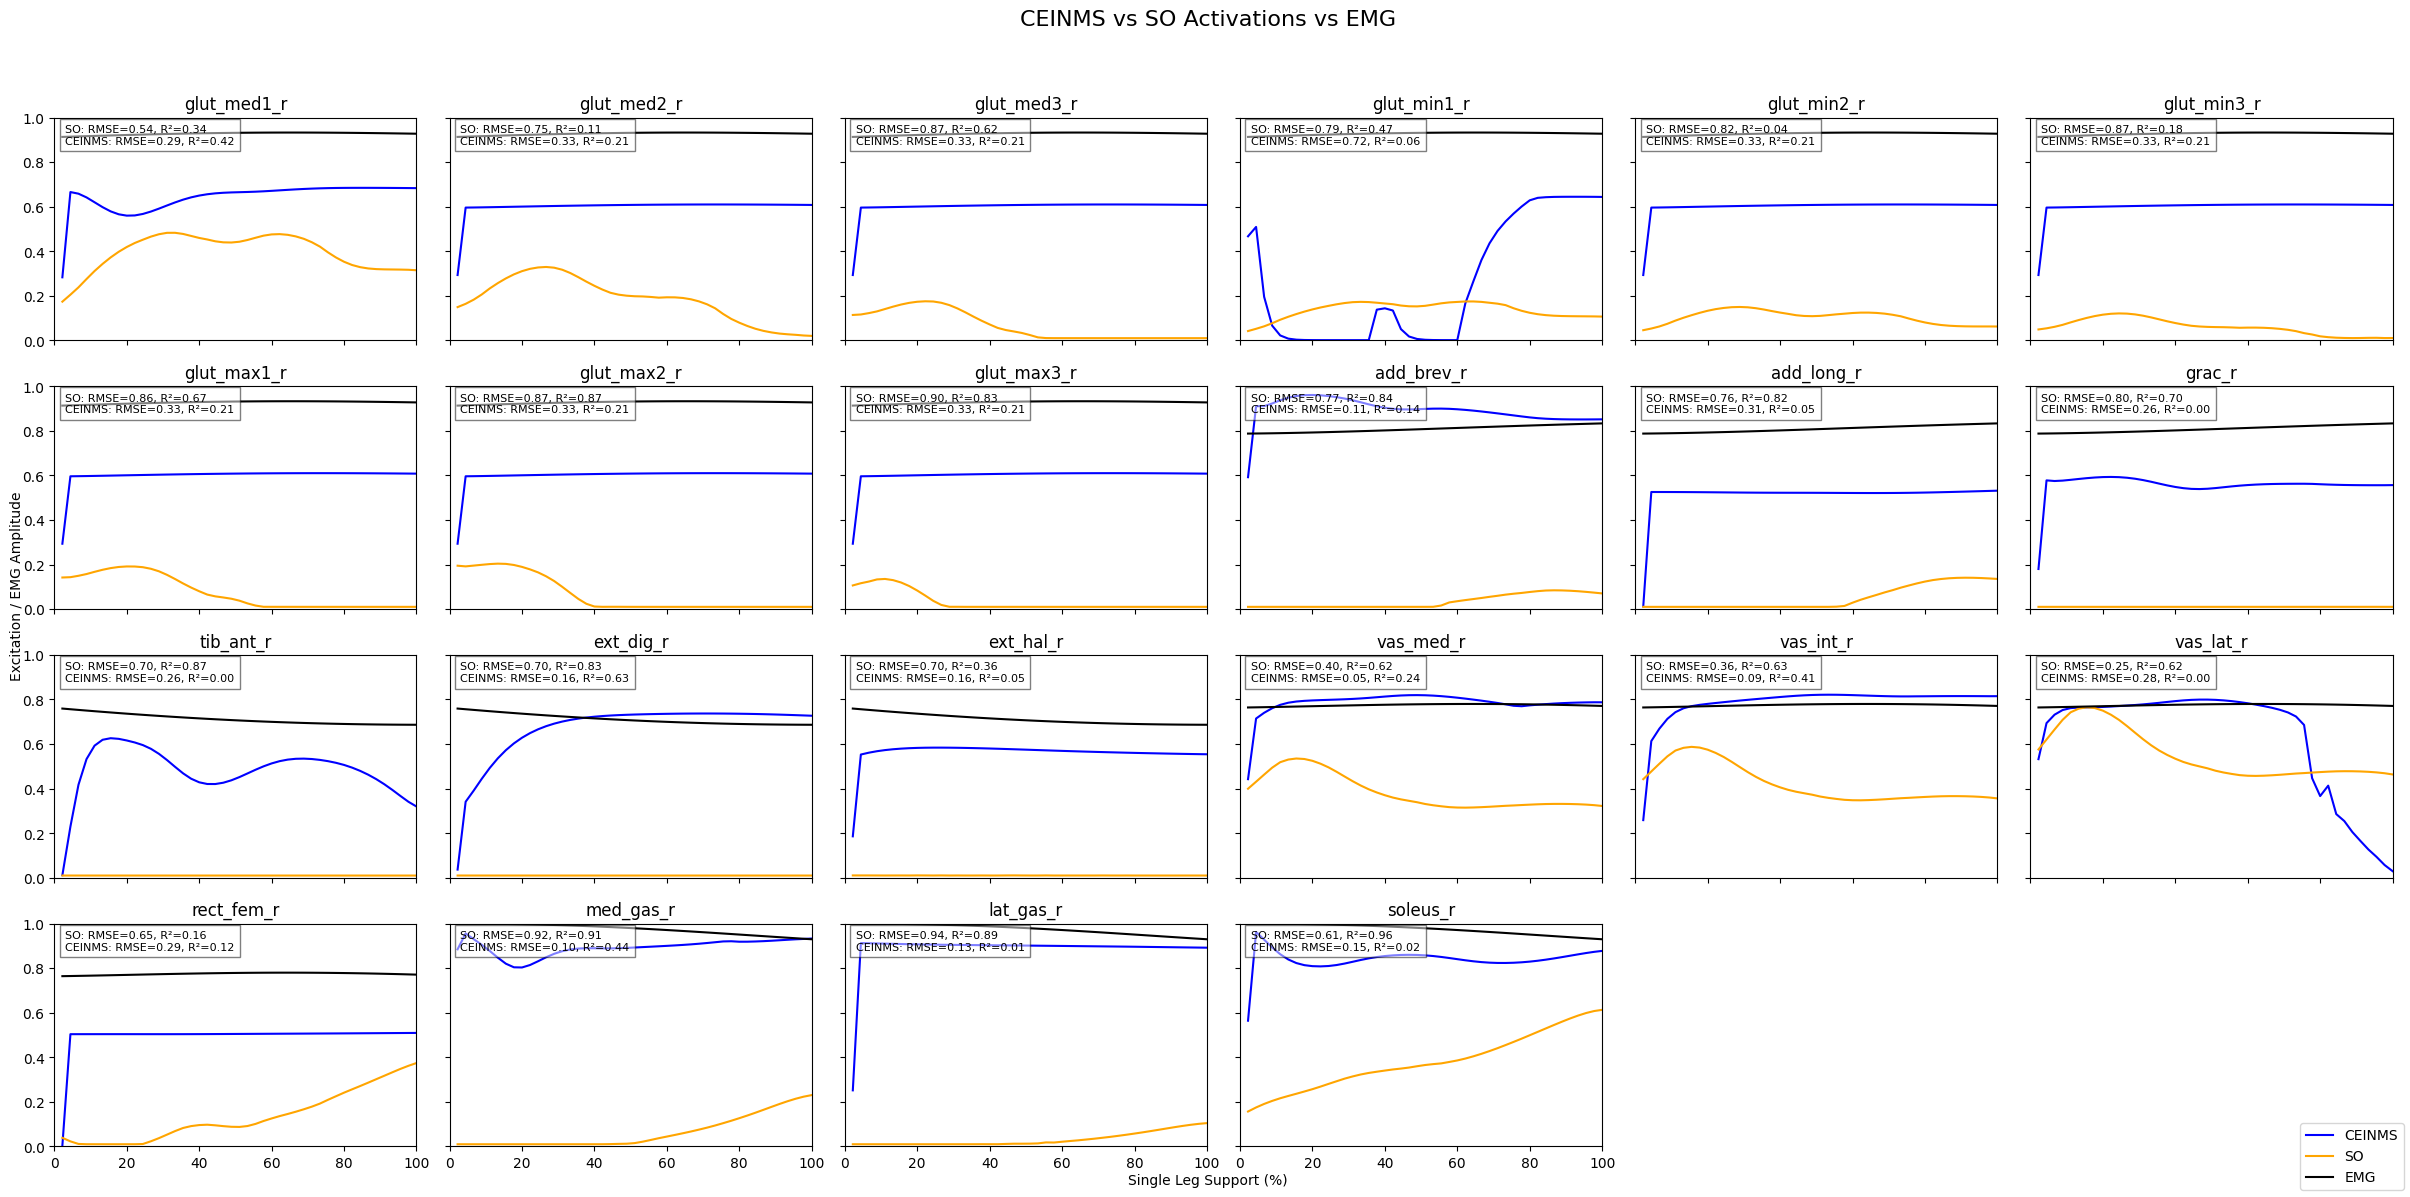

In [37]:
# Crop data to the common range for the activation comparison

start_time = max(ceinms_activations['time'].iloc[0], so_activations['time'].iloc[0], emg_data['time'].iloc[0])
end_time   = min(ceinms_activations['time'].iloc[-1], so_activations['time'].iloc[-1], emg_data['time'].iloc[-1])

ceinms_activations = ceinms_activations[(ceinms_activations['time'] >= start_time) & (ceinms_activations['time'] <= end_time)]
so_activations     = so_activations[(so_activations['time'] >= start_time) & (so_activations['time'] <= end_time)]
emg_data           = emg_data[(emg_data['time'] >= start_time) & (emg_data['time'] <= end_time)]


# Normalize Time to Percentage of Single Leg Support

sls_duration = end_time - start_time
so_activations     = normalize_time_act(so_activations, start_time, sls_duration)
ceinms_activations = normalize_time_act(ceinms_activations, start_time, sls_duration)
emg_data           = normalize_time_act(emg_data, start_time, sls_duration)


# EMG MAPPING and Filter Valid Muscles


emg_mappings = {
    'glut_med1_r': 'RGLTMED', 'glut_med2_r': 'RGLTMED', 'glut_med3_r': 'RGLTMED',
    'glut_min1_r': 'RGLTMED', 'glut_min2_r': 'RGLTMED', 'glut_min3_r': 'RGLTMED',
    'glut_max1_r': 'RGLTMED', 'glut_max2_r': 'RGLTMED', 'glut_max3_r': 'RGLTMED',
    'add_brev_r': 'RADDLONG', 'add_long_r': 'RADDLONG', 'grac_r': 'RADDLONG',
    'bifemlh_r': 'RBF', 'bifemsh_r': 'RBF', 'semimem_r': 'RBF', 'semiten_r': 'RBF',
    'tib_ant_r': 'RTA', 'ext_dig_r': 'RTA', 'ext_hal_r': 'RTA',
    'vas_med_r': 'RRF', 'vas_int_r': 'RRF', 'vas_lat_r': 'RRF', 'rect_fem_r': 'RRF',
    'med_gas_r': 'RGM', 'lat_gas_r': 'RGM', 'soleus_r': 'RGM'
}

valid_muscles = [
    muscle for muscle, emg_channel in emg_mappings.items()
    if muscle in ceinms_activations.columns and
       muscle in so_activations.columns and
       emg_channel in emg_data.columns
]


# Plotting the Activation Comparisons with RMSE/R² Annotations

n = len(valid_muscles)
cols = 6
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

# We'll use so_activations as the reference for the common time grid
target_length = len(so_activations['time'])

for i, muscle in enumerate(valid_muscles):
    emg_channel = emg_mappings[muscle]
    
    # Extract the curves from each DataFrame
    x_so = so_activations['time']
    y_so = so_activations[muscle]
    
    x_ceinms = ceinms_activations['time']
    y_ceinms = ceinms_activations[muscle]
    
    x_emg = emg_data['time']
    y_emg = emg_data[emg_channel]
    
    # Resample CEINMS and EMG curves to the target length if needed:
    if len(x_ceinms) != target_length:
        x_ceinms, y_ceinms = resample_curve(x_ceinms, y_ceinms, target_length)
    if len(x_emg) != target_length:
        x_emg, y_emg = resample_curve(x_emg, y_emg, target_length)

    
    # Plot the activation curves using the same time grid 
    axes[i].plot(x_so, y_ceinms, label='CEINMS', color='blue')
    axes[i].plot(x_so, y_so, label='SO', color='orange')
    axes[i].plot(x_so, y_emg, label='EMG', color='black')
    axes[i].set_title(muscle)
    axes[i].set_ylim(0, 1)
    axes[i].set_xlim(0, 100)
    
    # Compute RMSE and R²: compare to EMG 
    so_rmse, so_r2 = compute_rmse_r2(y_emg, y_so)
    ceinms_rmse, ceinms_r2 = compute_rmse_r2(y_emg, y_ceinms)
    
    # Annotate the subplot with the computed metrics
    annotation_text = (f"SO: RMSE={so_rmse:.2f}, R²={so_r2:.2f}\n"
                       f"CEINMS: RMSE={ceinms_rmse:.2f}, R²={ceinms_r2:.2f}")
    axes[i].text(0.03, 0.97, annotation_text, transform=axes[i].transAxes, fontsize=8,
                 verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, pad=4))

# Hide any unused subplots
for ax in axes[n:]:
    fig.delaxes(ax)

fig.suptitle("CEINMS vs SO Activations vs EMG", fontsize=16)
fig.text(0.5, 0.001, 'Single Leg Support (%)', ha='center')  
fig.text(0.001, 0.5, 'Excitation / EMG Amplitude', va='center', rotation='vertical')  
fig.legend(['CEINMS', 'SO', 'EMG'], loc='lower right')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# save figure in the folder
fig.savefig(os.path.join(simulations_dir, subject, trial_name, 'activations_comparison.png'), dpi=300)


# Compare joint moments

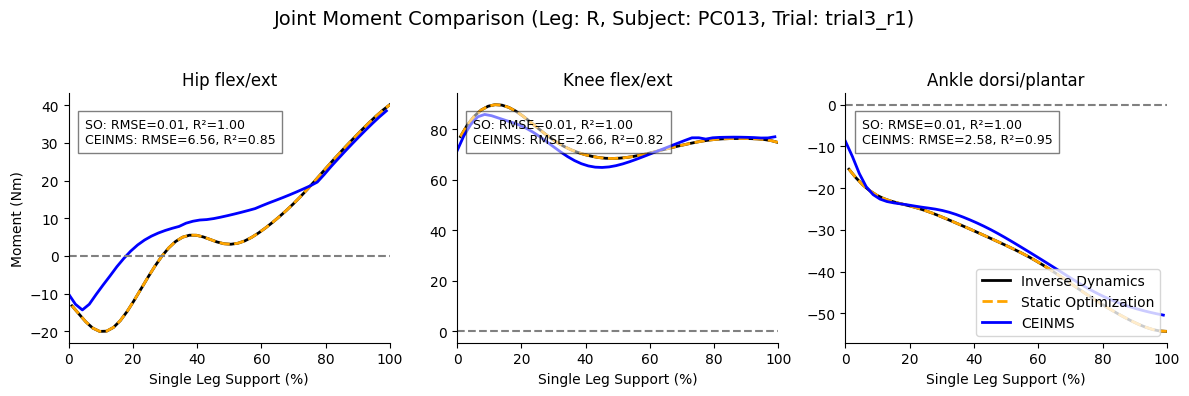

In [7]:
# Crop all data to shared time range for joint moment comparison
start_time = max(
    so_force['time'].iloc[0],
    torques['time'].iloc[0],
    id['time'].iloc[0]
)
end_time = min(
    so_force['time'].iloc[-1],
    torques['time'].iloc[-1],
    id['time'].iloc[-1]
)


so_force = crop_time(so_force)
torques = crop_time(torques)
inverse_dynamics = crop_time(id)

for ma_key in moment_arms:
    moment_arms[ma_key] = crop_time(moment_arms[ma_key])

# Normalize time to percentage of single leg support 
sls_duration = end_time - start_time

so_force = normalize_time(so_force)
torques = normalize_time(torques)
inverse_dynamics = normalize_time(inverse_dynamics)
for ma_key in moment_arms:
    moment_arms[ma_key] = normalize_time(moment_arms[ma_key])

# Compute SO joint moments (sum force × moment arm)
so_moments = {'time': so_force['time']}
for joint_key in joint_suffix:
    so_name = joint_suffix[joint_key]['so']
    ma_df = moment_arms[so_name]
    common_muscles = [m for m in ma_df.columns if m in so_force.columns and m != 'time']
    moment = sum(so_force[m] * ma_df[m] for m in common_muscles)
    so_moments[so_name] = moment.values  # ensure the moment values are arrays

so_df = pd.DataFrame(so_moments)

# Plot the results and compute metrics
label_map = {
    'hip': 'Hip flex/ext',
    'knee': 'Knee flex/ext',
    'ankle': 'Ankle dorsi/plantar'
}

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
axes = axes.flatten()

for i, joint_key in enumerate(['hip', 'knee', 'ankle']):
    joint_names = joint_suffix[joint_key]

    # Extract columns
    time_id = inverse_dynamics['time']
    id_moment = inverse_dynamics[joint_names['id']]
    
    time_so = so_df['time']
    so_moment = so_df[joint_names['so']]
    
    time_ceinms = torques['time']
    ceinms_moment = torques[joint_names['ceinms']]

    # Compute RMSE and R² (SO vs ID)
    so_rmse, so_r2 = compute_rmse_r2(id_moment, so_moment)
    
    # Compute RMSE and R² (CEINMS vs ID)
    ceinms_rmse, ceinms_r2 = compute_rmse_r2(id_moment, ceinms_moment)

    ax = axes[i]
    ax.plot(time_id, id_moment, label='Inverse Dynamics', color='black', linewidth=2.0)
    ax.plot(time_so, so_moment, label='Static Optimization', color='orange', linewidth=2.0, linestyle='--')
    ax.plot(time_ceinms, ceinms_moment, label='CEINMS', color='blue', linewidth=2.0)


    ax.axhline(0, color='gray', linestyle='--')
    ax.set_title(label_map[joint_key])
    ax.set_xlim(0, 100)  # clamp x-axis to 0–100%
    ax.set_xlabel('Single Leg Support (%)')
    if i == 0:
        ax.set_ylabel('Moment (Nm)')
    if i == 2:
        ax.legend(loc='lower right')

    # Remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Annotate the subplot with RMSE and R²
    annotation_text = (f"SO: RMSE={so_rmse:.2f}, R²={so_r2:.2f}\n"
                       f"CEINMS: RMSE={ceinms_rmse:.2f}, R²={ceinms_r2:.2f}")
    ax.text(0.05, 0.90, annotation_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, pad=5))

fig.suptitle(f'Joint Moment Comparison (Leg: {leg.upper()}, Subject: {subject}, Trial: {trial_name})', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Compare muscle forces


File not found: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC002\trial1_r1\ceinms\execution\MuscleForces.sto
File not found: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC002\trial3_r1\ceinms\execution\MuscleForces.sto
File not found: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC003\trial2_r1\ceinms\execution\MuscleForces.sto
File not found: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC003\trial3_r1\ceinms\execution\MuscleForces.sto
File not found: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC006\trial1_r1\ceinms\execution\MuscleForces.sto
File not found: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC006\trial3_r1\ceinms\execution\MuscleForces.sto
File not found: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC013\trial1_r1\ceinms\execution\MuscleForces.sto
File not found: C:\Git\opensim_tutorial\tutorials\Cereb

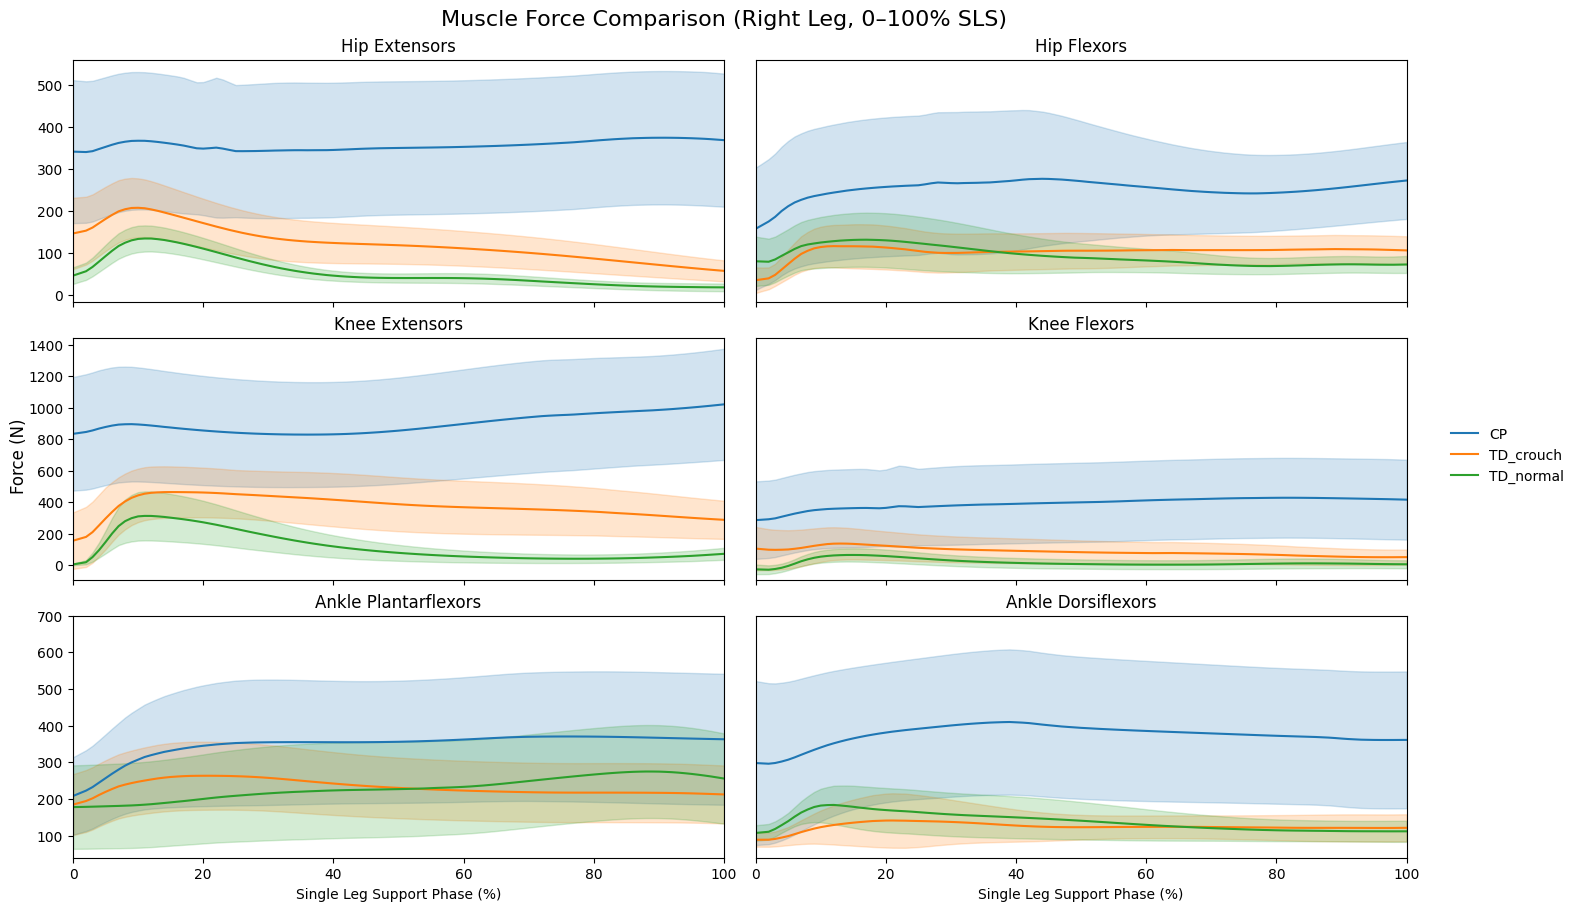

In [21]:
# Subject groups
cp_subjects = ['PC002', 'PC003', 'PC006', 'PC013']
td_subjects = ['TD006', 'TD013', 'TD017', 'TD021', 'TD023', 'TD026']

# Trial types
cp_trials = ['trial1_r1', 'trial2_r1', 'trial3_r1']
td_crouch_trials = ['crouch1_r1', 'crouch2_r1', 'crouch3_r1']
td_normal_trials = ['normal1_r1', 'normal2_r1', 'normal3_r1']

# Muscle groups (right leg only)
muscle_groups = {
    'hip_extensors': ['add_long_r', 'add_mag1_r', 'add_mag2_r', 'add_mag3_r', 'bifemlh_r', 'glut_max1_r', 'glut_max2_r', 'glut_max3_r', 'glut_med3_r', 'glut_min3_r', 'semimem_r', 'semiten_r'],
    'hip_flexors': ['add_brev_r', 'add_long_r', 'glut_med1_r', 'glut_min1_r', 'grac_r', 'iliacus_r', 'pect_r', 'psoas_r', 'rect_fem_r', 'sar_r', 'tfl_r'],
    'knee_extensors': ['rect_fem_r', 'vas_int_r', 'vas_lat_r', 'vas_med_r'],
    'knee_flexors': ['bifemlh_r', 'bifemsh_r', 'grac_r', 'lat_gas_r', 'med_gas_r', 'sar_r', 'semimem_r', 'semiten_r'],
    'ankle_plantarflexors': ['flex_dig_r', 'flex_hal_r', 'lat_gas_r', 'med_gas_r', 'per_brev_r', 'per_long_r', 'soleus_r', 'tib_post_r'],
    'ankle_dorsiflexors': ['ext_dig_r', 'ext_hal_r', 'per_tert_r', 'tib_ant_r']
}

# === HELPER FUNCTIONS ===
def load_sto(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    start_idx = next(i for i, line in enumerate(lines) if 'endheader' in line.lower()) + 1
    return pd.read_csv(StringIO(''.join(lines[start_idx:])), delim_whitespace=True)

def resample_to_percent_phase(series, target_len=101):
    n = series.shape[0]
    old_x = np.linspace(0, 100, n)
    new_x = np.linspace(0, 100, target_len)
    if isinstance(series, pd.Series):
        f = interp1d(old_x, series.values, kind='linear')
        return pd.Series(f(new_x))
    elif isinstance(series, pd.DataFrame):
        return pd.DataFrame({col: interp1d(old_x, series[col].values, kind='linear')(new_x) for col in series.columns})

def process_subject(subject, trial):
    trial_path = simulations_dir / subject / trial / 'ceinms' / 'execution' / 'MuscleForces.sto'
    if not trial_path.exists():
        print(f"File not found: {trial_path}")
        return {}
    df = load_sto(trial_path)
    trial_data = {}
    for group_name, muscle_list in muscle_groups.items():
        valid_cols = [m for m in muscle_list if m in df.columns]
        if valid_cols:
            group_df = df[valid_cols]
            group_df_resampled = resample_to_percent_phase(group_df)
            trial_data[group_name] = group_df_resampled
    return trial_data

# === LOAD DATA ===
cp_data_all = []
td_crouch_data_all = []
td_normal_data_all = []

for subject in cp_subjects:
    for trial in cp_trials:
        data = process_subject(subject, trial)
        if data:
            cp_data_all.append(data)

for subject in td_subjects:
    for trial in td_crouch_trials:
        data = process_subject(subject, trial)
        if data:
            td_crouch_data_all.append(data)

for subject in td_subjects:
    for trial in td_normal_trials:
        data = process_subject(subject, trial)
        if data:
            td_normal_data_all.append(data)

print(f"Loaded {len(cp_data_all)} CP trials")
print(f"Loaded {len(td_crouch_data_all)} TD crouch trials")
print(f"Loaded {len(td_normal_data_all)} TD normal trials")

# === PLOTTING ===

group_labels = ['CP', 'TD_crouch', 'TD_normal']
group_data_list = [cp_data_all, td_crouch_data_all, td_normal_data_all]
group_trial_map = dict(zip(group_labels, group_data_list))

num_groups = len(muscle_groups)
cols = 2
rows = (num_groups + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows), constrained_layout=True, gridspec_kw={'left': 0.8})
axes = axes.flatten()

x_label_groups = ['ankle_plantarflexors', 'ankle_dorsiflexors']
y_tick_groups = ['hip_extensors', 'knee_extensors', 'ankle_plantarflexors']
legend_handles = []

# Custom y-limits
custom_y_max = {
    'hip_flexors': 500,
    'knee_flexors': 1400,
    'ankle_dorsiflexors': 700,
    'ankle_plantarflexors': 700
}

# === Start plotting ===
for idx, (group_name, _) in enumerate(muscle_groups.items()):
    ax = axes[idx]
    plotted = False

    for label, data_all in zip(group_labels, group_data_list):
        all_series = []

        for trial_data in data_all:
            if group_name in trial_data:
                series = trial_data[group_name]
                if isinstance(series, pd.DataFrame):
                    all_series.extend([series[col] for col in series.columns])
                elif isinstance(series, pd.Series):
                    all_series.append(series)

        if all_series:
            df_group = pd.concat(all_series, axis=1)
            mean = df_group.mean(axis=1)
            std_err = df_group.std(axis=1) / np.sqrt(df_group.shape[1])
            ci = 1.96 * std_err

            x_percent = np.linspace(0, 100, len(mean))
            line, = ax.plot(x_percent, mean, label=label)
            ax.fill_between(x_percent, mean - ci, mean + ci, alpha=0.2, color=line.get_color())

            if label not in [h.get_label() for h in legend_handles]:
                legend_handles.append(line)

            plotted = True

    ax.set_title(group_name.replace('_', ' ').title())
    ax.set_xlim(0, 100)

    # Apply custom y-limits
    if group_name in custom_y_max:
        ax.set_ylim(top=custom_y_max[group_name])

    if group_name in x_label_groups:
        ax.set_xlabel("Single Leg Support Phase (%)")
    else:
        ax.set_xticklabels([])

    if group_name in y_tick_groups:
        ax.tick_params(axis='y', labelleft=True)
    else:
        ax.tick_params(axis='y', left=False, labelleft=False)

    ax.set_ylabel("")
    ax.grid(False)

    if not plotted:
        ax.text(50, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

# Hide unused axes
for i in range(len(muscle_groups), len(axes)):
    fig.delaxes(axes[i])

# Shared legend and y-axis label
fig.legend(handles=legend_handles[:len(group_labels)], labels=group_labels,
           loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
fig.suptitle("Muscle Force Comparison (Right Leg, 0–100% SLS)", fontsize=16)
fig.text(-0.01, 0.5, "Force (N)", va='center', rotation='vertical', fontsize=12)

plt.show()


## Muscle force plots only for CP children

 Missing: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC002\trial1_r1\ceinms\execution\MuscleForces.sto
 Missing: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC002\trial3_r1\ceinms\execution\MuscleForces.sto
 Missing: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC003\trial2_r1\ceinms\execution\MuscleForces.sto
 Missing: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC003\trial3_r1\ceinms\execution\MuscleForces.sto
 Missing: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC006\trial1_r1\ceinms\execution\MuscleForces.sto
 Missing: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC006\trial3_r1\ceinms\execution\MuscleForces.sto
 Missing: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC013\trial1_r1\ceinms\execution\MuscleForces.sto
 Missing: C:\Git\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC013\trial2_r1\ce

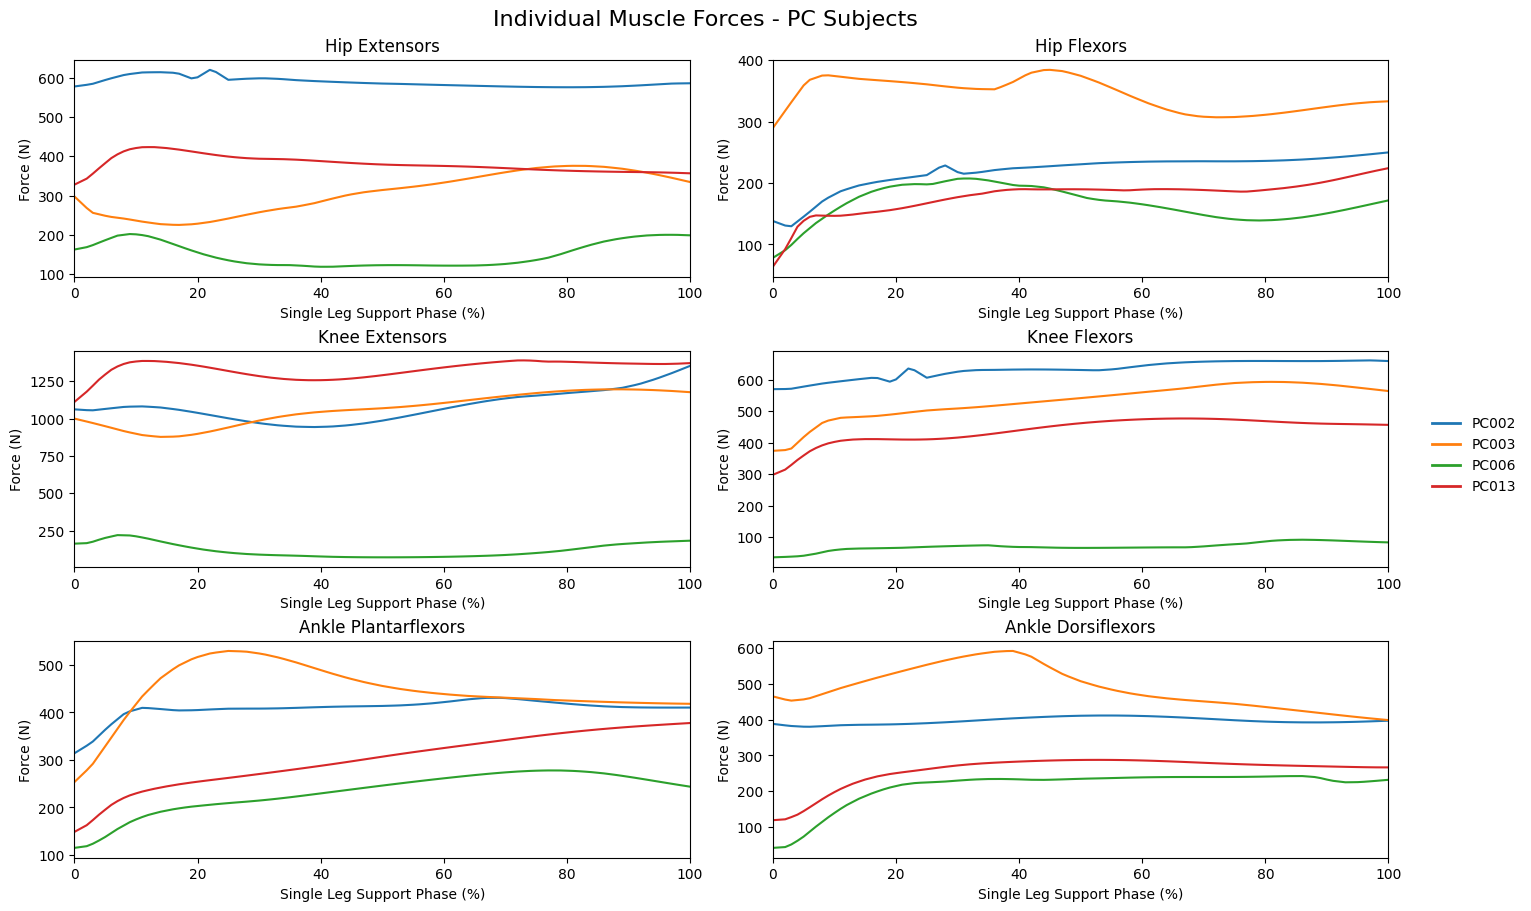

In [22]:
pc_subjects = ['PC002', 'PC003', 'PC006', 'PC013']
pc_trials = ['trial1_r1', 'trial2_r1', 'trial3_r1']

all_trials = []

for subject in pc_subjects:
    for trial in pc_trials:
        path = simulations_dir / subject / trial / 'ceinms' / 'execution' / 'MuscleForces.sto'
        if path.exists():
            df = load_sto(path)
            trial_data = {}
            for group, muscles in muscle_groups.items():
                valid = [m for m in muscles if m in df.columns]
                if valid:
                    group_df = df[valid]
                    trial_data[group] = resample_to_percent_phase(group_df)
            all_trials.append((subject, trial_data))
        else:
            print(f" Missing: {path}")

# Plotting

colors = {
    'PC002': 'tab:blue',
    'PC003': 'tab:orange',
    'PC006': 'tab:green',
    'PC013': 'tab:red'
}

num_groups = len(muscle_groups)
cols = 2
rows = (num_groups + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows), constrained_layout=True)
axes = axes.flatten()


legend_labels = {}

for idx, (group, _) in enumerate(muscle_groups.items()):
    ax = axes[idx]
    for subject, trial_data in all_trials:
        if group in trial_data:
            df = trial_data[group]
            mean_force = df.mean(axis=1)
            x = np.linspace(0, 100, len(mean_force))
            label = subject if subject not in legend_labels else None
            ax.plot(x, mean_force, color=colors[subject], label=label)
            legend_labels[subject] = colors[subject]
    ax.set_title(group.replace('_', ' ').title())
    ax.set_xlim(0, 100)
    ax.set_xlabel("Single Leg Support Phase (%)")
    ax.set_ylabel("Force (N)")
    ax.grid(False)

# Hide extra axes
for i in range(len(muscle_groups), len(axes)):
    fig.delaxes(axes[i])

# Custom clean legend
handles = [plt.Line2D([0], [0], color=clr, lw=2) for subj, clr in legend_labels.items()]
labels = list(legend_labels.keys())
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)

fig.suptitle("Individual Muscle Forces - PC Subjects", fontsize=16)
plt.show()


## Muscle forces CP Children (normalised to MVIC)

In [28]:
pc_subjects = ['PC002', 'PC003', 'PC006', 'PC013']
pc_trials = ['trial1_r1', 'trial2_r1', 'trial3_r1']

all_trials = []

for subject in pc_subjects:
    for trial in pc_trials:
        path = simulations_dir / subject / trial / 'ceinms' / 'execution' / 'MuscleForces.sto'
        ceinms_model_path = simulations_dir / subject / trial / 'ceinms' / 'calibratedSubject.xml'
        
        xml_ceimns = msk.XMLTools(ceinms_model_path)
        

Error loading XML file: [Errno 2] No such file or directory: 'C:\\Git\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC002\\trial1_r1\\ceinms\\calibratedSubject.xml'
Error loading XML file: [Errno 2] No such file or directory: 'C:\\Git\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC002\\trial3_r1\\ceinms\\calibratedSubject.xml'
Error loading XML file: [Errno 2] No such file or directory: 'C:\\Git\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC003\\trial2_r1\\ceinms\\calibratedSubject.xml'
Error loading XML file: [Errno 2] No such file or directory: 'C:\\Git\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC003\\trial3_r1\\ceinms\\calibratedSubject.xml'
Error loading XML file: [Errno 2] No such file or directory: 'C:\\Git\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC006\\trial1_r1\\ceinms\\calibratedSubject.xml'
Error loading XML file: [Errno 2] No such file or directory: 'C:\\Git\

TypeError: dir_find_containing() missing 1 required positional argument: 'name_to_find'

In [ ]:
pc_subjects = ['PC002', 'PC003', 'PC006', 'PC013']
pc_trials = ['trial1_r1', 'trial2_r1', 'trial3_r1']

all_trials = []

for subject in pc_subjects:
    for trial in pc_trials:
        path = simulations_dir / subject / trial / 'ceinms' / 'execution' / 'MuscleForces.sto'
        ceinms_model_path = simulations_dir / subject / trial / 'ceinms' / 'calibratedSubject.xml'
        
        xml_ceimns = msk.XMLTools.load(ceinms_model_path)
        
        if path.exists():
            df = load_sto(path)
            trial_data = {}
            for group, muscles in muscle_groups.items():
                valid = [m for m in muscles if m in df.columns]
                if valid:
                    group_df = df[valid]
                    trial_data[group] = resample_to_percent_phase(group_df)
            all_trials.append((subject, trial_data))
        else:
            print(f" Missing: {path}")

# Plotting

colors = {
    'PC002': 'tab:blue',
    'PC003': 'tab:orange',
    'PC006': 'tab:green',
    'PC013': 'tab:red'
}

num_groups = len(muscle_groups)
cols = 2
rows = (num_groups + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows), constrained_layout=True)
axes = axes.flatten()


legend_labels = {}

for idx, (group, _) in enumerate(muscle_groups.items()):
    ax = axes[idx]
    for subject, trial_data in all_trials:
        if group in trial_data:
            df = trial_data[group]
            mean_force = df.mean(axis=1)
            os_analysis.subjects[subject][trial_name]
            x = np.linspace(0, 100, len(mean_force))
            label = subject if subject not in legend_labels else None
            ax.plot(x, mean_force, color=colors[subject], label=label)
            legend_labels[subject] = colors[subject]
    ax.set_title(group.replace('_', ' ').title())
    ax.set_xlim(0, 100)
    ax.set_xlabel("Single Leg Support Phase (%)")
    ax.set_ylabel("Force (N)")
    ax.grid(False)

# Hide extra axes
for i in range(len(muscle_groups), len(axes)):
    fig.delaxes(axes[i])

# Custom clean legend
handles = [plt.Line2D([0], [0], color=clr, lw=2) for subj, clr in legend_labels.items()]
labels = list(legend_labels.keys())
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)

fig.suptitle("Individual Muscle Forces - PC Subjects", fontsize=16)
plt.show()


In [24]:
trial_data

{'hip_extensors':        add_long_r  add_mag1_r  add_mag2_r  add_mag3_r  bifemlh_r  glut_max1_r  \
 0    4.094170e-12    0.085512    0.228381   99.317500  363.04100     97.72500   
 1    8.094849e-11    2.008732    1.525750  102.431485  382.83646    111.08381   
 2    1.578028e-10    3.931952    2.823118  105.545470  402.63192    124.44262   
 3    4.788513e+00    4.530673    3.383156  107.733880  434.50516    150.56596   
 4    1.027778e+01    4.935564    3.835291  109.786840  468.14588    178.55728   
 ..            ...         ...         ...         ...        ...          ...   
 96   1.961598e+02   10.321603    0.000054   49.314388  563.17092    311.25740   
 97   1.963233e+02    9.642072    0.000025   48.515341  563.49569    310.97305   
 98   1.964960e+02    8.966746    0.000063   47.718046  563.83432    310.66326   
 99   1.967310e+02    8.320148    0.000553   46.932723  564.26766    310.17963   
 100  1.969660e+02    7.673550    0.001043   46.147400  564.70100    309.69600   

# Calculating RMSE and R squared for muscle activations and joint moments

In [ ]:
# Helper functions


def resample_to_percent_phase(df, target_len=101):
    """
    Resample a DataFrame with a time (or percent phase) column to exactly `target_len` rows.
    The function assumes that the rows are in order along the phase/time axis.
    """
    n = df.shape[0]
    old_x = np.linspace(0, 100, n)
    new_x = np.linspace(0, 100, target_len)
    resampled_data = {}
    for col in df.columns:
        if col == 'time':
            resampled_data[col] = new_x
        else:
            f = interp1d(old_x, df[col].values, kind='linear', fill_value="extrapolate")
            resampled_data[col] = f(new_x)
    return pd.DataFrame(resampled_data)

def crop_time(df, start_time, end_time):
    """Crop DataFrame rows to data between start_time and end_time."""
    return df[(df['time'] >= start_time) & (df['time'] <= end_time)].reset_index(drop=True)

def normalize_time(df, start_time, duration):
    """
    Normalize the 'time' column to a percentage scale (0-100) using given start_time and duration.
    """
    df = df.copy()
    df['time'] = 100 * (df['time'] - start_time) / duration
    return df

def compute_rmse_r2(y_true, y_pred):
    """
    Compute RMSE and R² between two 1D arrays (or Series).
    If arrays have different lengths, y_pred is interpolated onto y_true's grid.
    Ignores indices with NaN values.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # If lengths differ, interpolate y_pred onto y_true's grid:
    if len(y_true) != len(y_pred):
        x_old = np.linspace(0, 1, len(y_pred))
        x_new = np.linspace(0, 1, len(y_true))
        y_pred = np.interp(x_new, x_old, y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if np.sum(mask) == 0:
        return np.nan, np.nan
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)
    return rmse, r2

def fix_time_scale(df, expected_inc=0.01, factor=10):
    """
    Check the median time increment of the DataFrame.
    If it is significantly lower than expected_inc, multiply the 'time'
    column by the specified factor. This is used for TD data.
    """
    dt = df['time'].diff().median()
    if dt < expected_inc * 0.5:
        df = df.copy()
        df['time'] *= factor
    return df

def compute_so_joint_moments(so_force, moment_arms, joint_suffix):
    """
    Compute SO joint moments by summing the product of force and moment arm
    for each joint and return the results as a DataFrame.
    """
    so_moments = {"time": so_force["time"]}
    for joint_key in joint_suffix:
        so_name = joint_suffix[joint_key]["so"]
        ma_df = moment_arms[so_name]
        # Determine common muscle columns that exist in both so_force and the moment arm file,
        # excluding the 'time' column.
        common_muscles = [m for m in ma_df.columns if m in so_force.columns and m != "time"]
        # Use the original sum() without np.nansum if you’re confident there are no NaNs.
        moment = sum(so_force[m] * ma_df[m] for m in common_muscles)
        so_moments[so_name] = moment.values
    return pd.DataFrame(so_moments)


Error loading activation files for PC002 trial1_r1: [Errno 2] No such file or directory: 'C:\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC002\\trial1_r1\\Results_SO_and_MA\\StaticOptimization_activation.sto'
Error loading activation files for PC002 trial3_r1: [Errno 2] No such file or directory: 'C:\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC002\\trial3_r1\\Results_SO_and_MA\\StaticOptimization_activation.sto'
Error loading activation files for PC003 trial2_r1: [Errno 2] No such file or directory: 'C:\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC003\\trial2_r1\\Results_SO_and_MA\\StaticOptimization_activation.sto'
Error loading activation files for PC003 trial3_r1: [Errno 2] No such file or directory: 'C:\\opensim_tutorial\\tutorials\\Cerebral_Palsy_Project\\Simulations\\PC003\\trial3_r1\\Results_SO_and_MA\\StaticOptimization_activation.sto'
Error loading activation files for PC006 trial1_r1: [Errno 2] No such fi

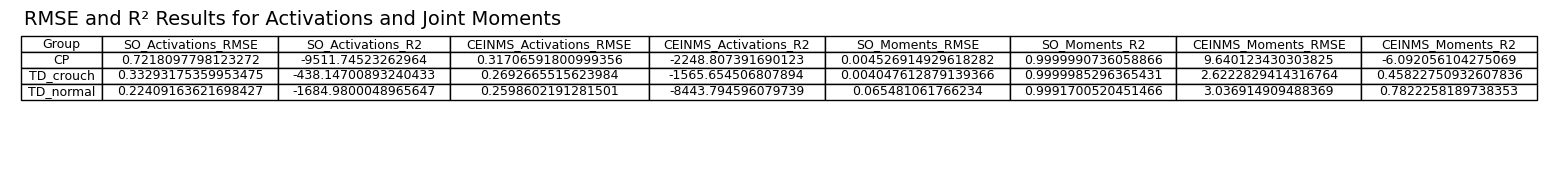

In [ ]:
# Subjects & trials 
cp_subjects = ['PC002', 'PC003', 'PC006', 'PC013']
td_subjects = ['TD006', 'TD013', 'TD017', 'TD021', 'TD023', 'TD026']

cp_trials = ['trial1_r1', 'trial2_r1', 'trial3_r1']
td_crouch_trials = ['crouch1_r1', 'crouch2_r1', 'crouch3_r1']
td_normal_trials = ['normal1_r1', 'normal2_r1', 'normal3_r1']

# Create a dictionary mapping group labels
group_trials = {
    'CP': [(s, t) for s in cp_subjects for t in cp_trials],
    'TD_crouch': [(s, t) for s in td_subjects for t in td_crouch_trials],
    'TD_normal': [(s, t) for s in td_subjects for t in td_normal_trials]
}

emg_mappings = {
    'glut_med1_r': 'RGLTMED', 'glut_med2_r': 'RGLTMED', 'glut_med3_r': 'RGLTMED',
    'glut_min1_r': 'RGLTMED', 'glut_min2_r': 'RGLTMED', 'glut_min3_r': 'RGLTMED',
    'glut_max1_r': 'RGLTMED', 'glut_max2_r': 'RGLTMED', 'glut_max3_r': 'RGLTMED',
    'add_brev_r': 'RADDLONG', 'add_long_r': 'RADDLONG', 'grac_r': 'RADDLONG',
    'bifemlh_r': 'RBF', 'bifemsh_r': 'RBF', 'semimem_r': 'RBF', 'semiten_r': 'RBF',
    'tib_ant_r': 'RTA', 'ext_dig_r': 'RTA', 'ext_hal_r': 'RTA',
    'vas_med_r': 'RRF', 'vas_int_r': 'RRF', 'vas_lat_r': 'RRF', 'rect_fem_r': 'RRF',
    'med_gas_r': 'RGM', 'lat_gas_r': 'RGM', 'soleus_r': 'RGM'
}


valid_muscles = list(emg_mappings.keys())

joint_suffix = {
    'hip':   {'so': 'hip_flexion_r',  'ceinms': 'hip_flexion_r',  'id': 'hip_flexion_r_moment'},
    'knee':  {'so': 'knee_angle_r',   'ceinms': 'knee_angle_r',   'id': 'knee_angle_r_moment'},
    'ankle': {'so': 'ankle_angle_r',  'ceinms': 'ankle_angle_r',  'id': 'ankle_angle_r_moment'}
}


# TRIAL PROCESSING FUNCTION


def process_trial(subject, trial):
    """
    Process a single trial:
      - Loads activation, EMG, joint moment, and force files.
      - For subjects in TD groups, fixes the time scale.
      - Computes muscle activation metrics (SO and CEINMS vs. EMG) for each muscle.
      - Computes SO joint moments using a helper function (or computes them if not precomputed)
        and then computes joint moment metrics (SO and CEINMS vs. inverse dynamics).
    Returns a dictionary with RMSE and R² metrics.
    """
    trial_folder = simulations_dir / subject / trial

    # ----- Load files for muscle activations -----
    so_activation_path = trial_folder / "Results_SO_and_MA" / "StaticOptimization_activation.sto"
    ceinms_activation_path = trial_folder / "ceinms" / "execution" / "Activations.sto"
    emg_path = trial_folder / "processed_emg_signals.mot"

    try:
        so_act = load_sto(str(so_activation_path))
        ceinms_act = load_sto(str(ceinms_activation_path))
        emg = load_sto(str(emg_path))
    except Exception as e:
        print(f"Error loading activation files for {subject} {trial}: {e}")
        return None

    # If subject belongs to TD group, fix time scale (multiply time by 10)
    if subject in td_subjects:
        so_act = fix_time_scale(so_act)
        ceinms_act = fix_time_scale(ceinms_act)
        emg = fix_time_scale(emg)

    # Crop activation data to a common time window
    start_time_act = max(so_act['time'].iloc[0], ceinms_act['time'].iloc[0], emg['time'].iloc[0])
    end_time_act = min(so_act['time'].iloc[-1], ceinms_act['time'].iloc[-1], emg['time'].iloc[-1])
    so_act = crop_time(so_act, start_time_act, end_time_act)
    ceinms_act = crop_time(ceinms_act, start_time_act, end_time_act)
    emg = crop_time(emg, start_time_act, end_time_act)
    
    # Compute muscle activation metrics over all muscles from the EMG mapping.
    so_act_rmse_vals, so_act_r2_vals = [], []
    ceinms_act_rmse_vals, ceinms_act_r2_vals = [], []
    for muscle in list(emg_mappings.keys()):
        emg_channel = emg_mappings[muscle]
        if (muscle in so_act.columns) and (emg_channel in emg.columns):
            rmse_val, r2_val = compute_rmse_r2(emg[emg_channel], so_act[muscle])
            so_act_rmse_vals.append(rmse_val)
            so_act_r2_vals.append(r2_val)
        if (muscle in ceinms_act.columns) and (emg_channel in emg.columns):
            rmse_val, r2_val = compute_rmse_r2(emg[emg_channel], ceinms_act[muscle])
            ceinms_act_rmse_vals.append(rmse_val)
            ceinms_act_r2_vals.append(r2_val)
    
    so_act_rmse_avg = np.mean(so_act_rmse_vals) if so_act_rmse_vals else np.nan
    so_act_r2_avg = np.mean(so_act_r2_vals) if so_act_r2_vals else np.nan
    ceinms_act_rmse_avg = np.mean(ceinms_act_rmse_vals) if ceinms_act_rmse_vals else np.nan
    ceinms_act_r2_avg = np.mean(ceinms_act_r2_vals) if ceinms_act_r2_vals else np.nan

    # ----- Load files for joint moments -----
    so_force_path = trial_folder / "Results_SO_and_MA" / "StaticOptimization_force.sto"
    ceinms_torque_path = trial_folder / "ceinms" / "execution" / "Torques.sto"
    id_path = trial_folder / "inverse_dynamics.sto"
    
    try:
        so_force = load_sto(str(so_force_path))
        ceinms_torques = load_sto(str(ceinms_torque_path))
        inverse_dynamics = load_sto(str(id_path))
    except Exception as e:
        print(f"Error loading joint moment files for {subject} {trial}: {e}")
        return None

    # Fix time scales for TD joint moment files (if needed)
    if subject in td_subjects:
        so_force = fix_time_scale(so_force)
        ceinms_torques = fix_time_scale(ceinms_torques)
        inverse_dynamics = fix_time_scale(inverse_dynamics)

    # Load moment arm files for joints from SO (for hip, knee, and ankle)
    moment_arms = {}
    for joint in joint_suffix.keys():
        ma_filename = f"MuscleAnalysis_MomentArm_{joint_suffix[joint]['so']}.sto"
        ma_path = trial_folder / "Results_SO_and_MA" / ma_filename
        try:
            moment_arms[joint_suffix[joint]['so']] = load_sto(str(ma_path))
        except Exception as e:
            print(f"Error loading moment arm file {ma_filename} for {subject} {trial}: {e}")
            moment_arms[joint_suffix[joint]['so']] = None
    
    # Crop joint moment data to a common time window
    start_time_mom = max(so_force['time'].iloc[0],
                         ceinms_torques['time'].iloc[0],
                         inverse_dynamics['time'].iloc[0])
    end_time_mom = min(so_force['time'].iloc[-1],
                       ceinms_torques['time'].iloc[-1],
                       inverse_dynamics['time'].iloc[-1])
    so_force = crop_time(so_force, start_time_mom, end_time_mom)
    ceinms_torques = crop_time(ceinms_torques, start_time_mom, end_time_mom)
    inverse_dynamics = crop_time(inverse_dynamics, start_time_mom, end_time_mom)
    for key in moment_arms:
        if moment_arms[key] is not None:
            moment_arms[key] = crop_time(moment_arms[key], start_time_mom, end_time_mom)
    
    # Normalize time to percentage of single leg support
    sls_duration = end_time_mom - start_time_mom
    so_force = normalize_time(so_force, start_time_mom, sls_duration)
    ceinms_torques = normalize_time(ceinms_torques, start_time_mom, sls_duration)
    inverse_dynamics = normalize_time(inverse_dynamics, start_time_mom, sls_duration)
    for key in moment_arms:
        if moment_arms[key] is not None:
            moment_arms[key] = normalize_time(moment_arms[key], start_time_mom, sls_duration)
    
    # ----- Compute SO joint moments using our helper function -----
    so_joint_df = compute_so_joint_moments(so_force, moment_arms, joint_suffix)
    
    # Compute joint moment metrics by comparing model results vs. inverse dynamics.
    so_mom_rmse_list, so_mom_r2_list = [], []
    ceinms_mom_rmse_list, ceinms_mom_r2_list = [], []
    for joint, cols in joint_suffix.items():
        id_col = cols['id']
        # For SO joint moments: compare so_joint_df vs inverse dynamics
        if (cols['so'] in so_joint_df.columns) and (id_col in inverse_dynamics.columns):
            rmse_val, r2_val = compute_rmse_r2(inverse_dynamics[id_col], so_joint_df[cols['so']])
            so_mom_rmse_list.append(rmse_val)
            so_mom_r2_list.append(r2_val)
        # For CEINMS joint moments: compare ceinms_torques vs inverse dynamics
        ceinms_col = cols['ceinms']
        if (ceinms_col in ceinms_torques.columns) and (id_col in inverse_dynamics.columns):
            rmse_val, r2_val = compute_rmse_r2(inverse_dynamics[id_col], ceinms_torques[ceinms_col])
            ceinms_mom_rmse_list.append(rmse_val)
            ceinms_mom_r2_list.append(r2_val)
    
    so_mom_rmse_avg = np.mean(so_mom_rmse_list) if so_mom_rmse_list else np.nan
    so_mom_r2_avg = np.mean(so_mom_r2_list) if so_mom_r2_list else np.nan
    ceinms_mom_rmse_avg = np.mean(ceinms_mom_rmse_list) if ceinms_mom_rmse_list else np.nan
    ceinms_mom_r2_avg = np.mean(ceinms_mom_r2_list) if ceinms_mom_r2_list else np.nan

    # Compose the trial result dictionary
    trial_results = {
        "so_activation_rmse": so_act_rmse_avg,
        "so_activation_r2": so_act_r2_avg,
        "ceinms_activation_rmse": ceinms_act_rmse_avg,
        "ceinms_activation_r2": ceinms_act_r2_avg,
        "so_moments_rmse": so_mom_rmse_avg,
        "so_moments_r2": so_mom_r2_avg,
        "ceinms_moments_rmse": ceinms_mom_rmse_avg,
        "ceinms_moments_r2": ceinms_mom_r2_avg
    }
    return trial_results



# PROCESS ALL TRIALS AND AGGREGATE RESULTS BY GROUP


group_results = {}  # Will map group -> list of trial result dictionaries

for group_label, trials in group_trials.items():
    trial_results_list = []
    for subject, trial in trials:
        res = process_trial(subject, trial)
        if res is not None:
            trial_results_list.append(res)
    group_results[group_label] = trial_results_list

# Now, average the metrics for each group (averaging across trials)
final_results = []
for group_label, results_list in group_results.items():
    if results_list:
        df = pd.DataFrame(results_list)
        final_results.append({
            "Group": group_label,
            "SO_Activations_RMSE": df["so_activation_rmse"].mean(),
            "SO_Activations_R2": df["so_activation_r2"].mean(),
            "CEINMS_Activations_RMSE": df["ceinms_activation_rmse"].mean(),
            "CEINMS_Activations_R2": df["ceinms_activation_r2"].mean(),
            "SO_Moments_RMSE": df["so_moments_rmse"].mean(),
            "SO_Moments_R2": df["so_moments_r2"].mean(),
            "CEINMS_Moments_RMSE": df["ceinms_moments_rmse"].mean(),
            "CEINMS_Moments_R2": df["ceinms_moments_r2"].mean()
        })
    else:
        final_results.append({
            "Group": group_label,
            "SO_Activations_RMSE": np.nan,
            "SO_Activations_R2": np.nan,
            "CEINMS_Activations_RMSE": np.nan,
            "CEINMS_Activations_R2": np.nan,
            "SO_Moments_RMSE": np.nan,
            "SO_Moments_R2": np.nan,
            "CEINMS_Moments_RMSE": np.nan,
            "CEINMS_Moments_R2": np.nan
        })

df_final = pd.DataFrame(final_results)
print("RMSE and R² Metrics Across Groups")
print(df_final)


# Plot the Results as a Table

fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')
table_data = [df_final.columns.to_list()] + df_final.values.tolist()
the_table = ax.table(cellText=table_data, cellLoc='center', loc='upper left')
the_table.auto_set_font_size(False)
the_table.set_fontsize(9)
for col in range(len(df_final.columns)):
    the_table.auto_set_column_width(col)
plt.title("RMSE and R² Results for Activations and Joint Moments", fontsize=14)
plt.tight_layout()
plt.show()


# Compare calibrated and uncalibrated ceinms models


In [ ]:
uncal_model =r"C:\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC013\trial3_l1\ceinms\uncalibratedSubject.xml"
cal_model = uncal_model.replace('uncalibratedSubject.xml', 'calibratedSubject.xml')

# open both xmls and compare each mtu
ucal_model_xml = msk.bops.XMLTools().load(uncal_model)
cal_model_xml = msk.bops.XMLTools().load(cal_model)


In [ ]:
filename = r"C:\opensim_tutorial\tutorials\Cerebral_Palsy_Project\Simulations\PC002\trial2_analog_filtered_emg.csv"
emg_data = pd.read_csv(filename)

print(emg_data)
print(emg_data.max())

emg_data_normalised = emg_data / emg_data.max().max()

print(emg_data_normalised)

In [ ]:
# Parse the root elements of the XML trees
cal_root = cal_model_xml.getroot()
ucal_root = ucal_model_xml.getroot()

# Find all "mtu" elements in both models
cal_mtu_elements = cal_root.findall(".//mtu")
ucal_mtu_elements = ucal_root.findall(".//mtu")

# Create dictionaries for easy lookup by muscle name
cal_mtu_dict = {mtu.find("name").text: mtu for mtu in cal_mtu_elements}
ucal_mtu_dict = {mtu.find("name").text: mtu for mtu in ucal_mtu_elements}

# Loop through all muscles and compare "maxIsometricForce" and "tendonSlackLength"
comparison_results = []
for muscle_name, cal_mtu in cal_mtu_dict.items():
    if muscle_name in ucal_mtu_dict:
        ucal_mtu = ucal_mtu_dict[muscle_name]
        
        # Extract values for comparison
        cal_max_iso_force = float(cal_mtu.find("maxIsometricForce").text)
        ucal_max_iso_force = float(ucal_mtu.find("maxIsometricForce").text)
        
        cal_tendon_slack_length = float(cal_mtu.find("tendonSlackLength").text)
        ucal_tendon_slack_length = float(ucal_mtu.find("tendonSlackLength").text)
        
        # Store the comparison results
        comparison_results.append({
            "Muscle": muscle_name,
            "Calibrated_MaxIsometricForce": cal_max_iso_force,
            "Uncalibrated_MaxIsometricForce": ucal_max_iso_force,
            "Calibrated_TendonSlackLength": cal_tendon_slack_length,
            "Uncalibrated_TendonSlackLength": ucal_tendon_slack_length
        })

# Convert the results to a DataFrame for better visualization
comparison_df = pd.DataFrame(comparison_results)

# Display the comparison
print(comparison_df)

# make some plots
# Plot comparison of maxIsometricForce
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(comparison_df["Calibrated_MaxIsometricForce"], comparison_df["Uncalibrated_MaxIsometricForce"], 'o')
plt.xlabel("Calibrated Max Isometric Force (N)")
plt.ylabel("Uncalibrated Max Isometric Force (N)")

# Plot comparison of tendonSlackLength
plt.subplot(1, 2, 2)
plt.plot(comparison_df["Calibrated_TendonSlackLength"], comparison_df["Uncalibrated_TendonSlackLength"], 'o')
plt.xlabel("Calibrated Tendon Slack Length (m)")
plt.ylabel("Uncalibrated Tendon Slack Length (m)")
# Save the graph to the folder where calibrated and uncalibrated subjects are
def save_comparison_graph(cal_model_path, ucal_model_path, fig):
    # Determine the directory to save the graph
    save_dir = os.path.dirname(cal_model_path)
    save_path = os.path.join(save_dir, "ucal-cal.png")
    
    # Save the figure
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Graph saved at: {save_path}")

# Create a figure for the plots
fig = plt.figure(figsize=(12, 6))

# Plot comparison of maxIsometricForce
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(comparison_df["Calibrated_MaxIsometricForce"], comparison_df["Uncalibrated_MaxIsometricForce"], 'o')
ax1.set_xlabel("Calibrated Max Isometric Force (N)")
ax1.set_ylabel("Uncalibrated Max Isometric Force (N)")
ax1.set_title("Max Isometric Force Comparison")

# Plot comparison of tendonSlackLength
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(comparison_df["Calibrated_TendonSlackLength"], comparison_df["Uncalibrated_TendonSlackLength"], 'o')
ax2.set_xlabel("Calibrated Tendon Slack Length (m)")
ax2.set_ylabel("Uncalibrated Tendon Slack Length (m)")
ax2.set_title("Tendon Slack Length Comparison")

# Save the graph
save_comparison_graph(cal_model, uncal_model, fig)
